In [25]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output # Only for iPython

#Helper functions

In [26]:
def crossMat(a):
    """
    Returns the cross product matrix of vector 'a'.

    Parameters:
    a : np.ndarray
        A 3-element array representing a vector.

    Returns:
    A : np.ndarray
        The cross product matrix corresponding to vector 'a'.
    """
    A = np.array([[0, -a[2], a[1]],
                  [a[2], 0, -a[0]],
                  [-a[1], a[0], 0]])

    return A

In [27]:
def build_C(nv, A, visc, scale_factor=1.0):
    """
    Build the viscous damping matrix C using your variable names.

    Parameters
    ----------
    nv : int
        Number of vertices.
    A : float
        Cross-sectional area.
    visc : float
        Dynamic viscosity (Pa·s), e.g. water = 1e-3.
    scale_factor : float
        Optional multiplier to increase/decrease damping.

    Returns
    -------
    C : ndarray
        (2*nv, 2*nv) diagonal damping matrix.
    """
    ndof = 2 * nv
    C = np.zeros((ndof, ndof))

    # same formula you used: use radius from area
    equiv_radius = np.sqrt(A / np.pi)

    # same structure: 6πμR
    c_val = 6.0 * np.pi * visc * equiv_radius * scale_factor

    # fill diagonal using same DOF indexing as your code
    for k in range(nv):
        C[2*k, 2*k]       = c_val
        C[2*k+1, 2*k+1]   = c_val

    return C


In [28]:
def build_C_anisotropic(q, nv, deltaL,
                        visc_par, visc_perp):
    """
    Build an anisotropic viscous damping matrix C based on the
    current configuration q.

    visc_par  : drag coefficient along the local tangent (‖)
    visc_perp : drag coefficient along the local normal (⊥, larger)
    """

    ndof = 2 * nv
    C = np.zeros((ndof, ndof))

    # Loop over edges and accumulate local 2x2 drag matrices
    for e in range(nv - 1):
        # Node indices of this edge
        i1 = 2 * e
        i2 = 2 * (e + 1)

        x1, y1 = q[i1],     q[i1 + 1]
        x2, y2 = q[i2],     q[i2 + 1]

        dx, dy = x2 - x1, y2 - y1
        L = np.hypot(dx, dy) + 1e-12

        # Local tangent and normal (in global coordinates)
        tx, ty = dx / L, dy / L
        nx, ny = -ty, tx

        # Local 2x2 resistance tensor in global frame:
        # R = ξ‖ t tᵀ + ξ⊥ n nᵀ
        t = np.array([tx, ty])
        n = np.array([nx, ny])
        R = visc_par * np.outer(t, t) + visc_perp * np.outer(n, n)

        # Distribute this drag to the two nodes of the edge
        # (simple "lumped" scheme: half to each node)
        C[i1:i1+2, i1:i1+2] += 0.5 * R * deltaL
        C[i2:i2+2, i2:i2+2] += 0.5 * R * deltaL

    return C


In [29]:
def build_C_anisotropic_profile(q, nv, deltaL,
                                visc_par, visc_perp,
                                drag_profile=None):
    """
    Build an anisotropic viscous damping matrix C based on the
    current configuration q, with a per-node drag profile.

    visc_par  : drag coefficient along the local tangent (‖)
    visc_perp : drag coefficient along the local normal (⊥)
    drag_profile : array of length nv with multiplicative factors
                   for each node's drag (default = all ones).
    """
    ndof = 2 * nv
    C = np.zeros((ndof, ndof))

    if drag_profile is None:
        drag_profile = np.ones(nv)
    else:
        drag_profile = np.asarray(drag_profile)
        assert drag_profile.size == nv

    for e in range(nv - 1):
        # indices for the two nodes of this edge
        i1 = 2 * e
        i2 = 2 * (e + 1)

        x1, y1 = q[i1],     q[i1 + 1]
        x2, y2 = q[i2],     q[i2 + 1]

        dx, dy = x2 - x1, y2 - y1
        L = np.hypot(dx, dy) + 1e-12

        # Tangent and normal
        tx, ty = dx / L, dy / L
        nx, ny = -ty, tx

        t = np.array([tx, ty])
        n = np.array([nx, ny])

        # Local resistance tensor
        R = visc_par * np.outer(t, t) + visc_perp * np.outer(n, n)

        # Node-specific drag weights (head can be "bulkier")
        w1 = drag_profile[e]
        w2 = drag_profile[e + 1]

        C[i1:i1+2, i1:i1+2] += 0.5 * w1 * R * deltaL
        C[i2:i2+2, i2:i2+2] += 0.5 * w2 * R * deltaL

    return C


#Gradient and Hessian of elastic energies

In [30]:
def gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the derivative of bending energy E_k^b with respect to
    x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dF : np.ndarray
        Derivative of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Gradient of bending energy
    dkappa = kappa1 - kappaBar
    dF = gradKappa * EI * dkappa / l_k

    return dF

In [31]:
def hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the Hessian (second derivative) of bending energy E_k^b
    with respect to x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dJ : np.ndarray
        Hessian of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Compute the Hessian (second derivative of kappa)
    DDkappa1 = np.zeros((6, 6))

    norm2_e = norm_e**2
    norm2_f = norm_f**2

    Id3 = np.eye(3)

    # Helper matrices for second derivatives
    tt_o_tt = np.outer(tilde_t, tilde_t)
    tmp = np.cross(tf, tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    kb_o_d2e = np.outer(kb, m2e)

    D2kappa1De2 = (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / norm2_e - \
                  kappa1 / (chi * norm2_e) * (Id3 - np.outer(te, te)) + \
                  (kb_o_d2e + kb_o_d2e.T) / (4 * norm2_e)

    tmp = np.cross(te, tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = te_c_d2t_o_tt.T
    kb_o_d2f = np.outer(kb, m2f)

    D2kappa1Df2 = (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / norm2_f - \
                  kappa1 / (chi * norm2_f) * (Id3 - np.outer(tf, tf)) + \
                  (kb_o_d2f + kb_o_d2f.T) / (4 * norm2_f)
    D2kappa1DeDf = -kappa1 / (chi * norm_e * norm_f) * (Id3 + np.outer(te, tf)) \
                  + 1.0 / (norm_e * norm_f) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt + \
                  tt_o_te_c_d2t - crossMat(tilde_d2))
    D2kappa1DfDe = D2kappa1DeDf.T

    # Populate the Hessian of kappa
    DDkappa1[0:2, 0:2] = D2kappa1De2[0:2, 0:2]
    DDkappa1[0:2, 2:4] = -D2kappa1De2[0:2, 0:2] + D2kappa1DeDf[0:2, 0:2]
    DDkappa1[0:2, 4:6] = -D2kappa1DeDf[0:2, 0:2]
    DDkappa1[2:4, 0:2] = -D2kappa1De2[0:2, 0:2] + D2kappa1DfDe[0:2, 0:2]
    DDkappa1[2:4, 2:4] = D2kappa1De2[0:2, 0:2] - D2kappa1DeDf[0:2, 0:2] - \
                         D2kappa1DfDe[0:2, 0:2] + D2kappa1Df2[0:2, 0:2]
    DDkappa1[2:4, 4:6] = D2kappa1DeDf[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 0:2] = -D2kappa1DfDe[0:2, 0:2]
    DDkappa1[4:6, 2:4] = D2kappa1DfDe[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 4:6] = D2kappa1Df2[0:2, 0:2]

    # Hessian of bending energy
    dkappa = kappa1 - kappaBar
    dJ = 1.0 / l_k * EI * np.outer(gradKappa, gradKappa)
    dJ += 1.0 / l_k * dkappa * EI * DDkappa1

    return dJ

In [32]:
def gradEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    Calculate the gradient of the stretching energy with respect to the coordinates.

    Args:
    - xk (float): x coordinate of the current point
    - yk (float): y coordinate of the current point
    - xkp1 (float): x coordinate of the next point
    - ykp1 (float): y coordinate of the next point
    - l_k (float): reference length
    - EA (float): elastic modulus

    Returns:
    - F (np.array): Gradient array
    """
    F = np.zeros(4)
    F[0] = -(1.0 - np.sqrt((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0) / l_k) * ((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0)**(-0.5) / l_k * (-2.0 * xkp1 + 2.0 * xk)
    F[1] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (-0.2e1 * ykp1 + 0.2e1 * yk)
    F[2] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * xkp1 - 0.2e1 * xk)
    F[3] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * ykp1 - 0.2e1 * yk)

    F = 0.5 * EA * l_k * F  # Scale by EA and l_k

    return F

In [33]:
def hessEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    This function returns the 4x4 Hessian of the stretching energy E_k^s with
    respect to x_k, y_k, x_{k+1}, and y_{k+1}.
    """
    J = np.zeros((4, 4))  # Initialize the Hessian matrix
    J11 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J12 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (-2 * ykp1 + 2 * yk) / 0.2e1
    J13 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * xkp1 - 2 * xk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J14 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J22 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J23 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * xkp1 - 2 * xk) / 0.2e1
    J24 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * ykp1 - 2 * yk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J33 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * xkp1 - 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J34 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (2 * xkp1 - 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (2 * xkp1 - 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J44 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * ykp1 - 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k

    J = np.array([[J11, J12, J13, J14],
                   [J12, J22, J23, J24],
                   [J13, J23, J33, J34],
                   [J14, J24, J34, J44]])

    J *= 0.5 * EA * l_k

    return J

# Functions to create elastic force vector and its Hessian

In [34]:
def getFs(q, EA, deltaL):
  # q - DOF vector of size N
  # EA - stretching stiffness
  # deltaL - undeformed reference length (assume to be a scalar for this simple example)
  # Output:
  # Fs - a vector (negative gradient of elastic stretching force)
  # Js - a matrix (negative hessian of elastic stretching force)

  ndof = q.size # Number of DOFs
  N = ndof // 2 # Number of nodes

  Fs = np.zeros(ndof) # stretching force
  Js = np.zeros((ndof, ndof))

  for k in range(0, N-1):
      # May need to modify if network of beams
      # k-th stretching spring (USE A LOOP for the general case
      xkm1 = q[2*k] # x coordinate of the first node
      ykm1 = q[2*k+1] # y coordinate of the first node
      xk = q[2*k+2] # x coordinate of the second node
      yk = q[2*k+3] # y coordinate of the second node
      ind = np.arange(2*k, 2*k+4) # 0, 1, 2, 3 for k = 0
      gradEnergy = gradEs(xkm1, ykm1, xk, yk, deltaL, EA)
      hessEnergy = hessEs(xkm1, ykm1, xk, yk, deltaL, EA)

      Fs[ind] -= gradEnergy # force = - gradient of energy. Fs is the stretching force
      Js[np.ix_(ind, ind)] -= hessEnergy # index vector: 0:4

  return Fs, Js

In [35]:
def getFb(q, EI, deltaL, t, kappa_amp, omega, k_wave):
    """
    Updated bending force model to reduce lateral (Y) motion while keeping
    forward (X) propulsion. This version:

    - Uses a milder envelope: xi**0.5  → reduces large tail swings.
    - Uses symmetric traveling wave curvature (no bias, no 2harmonics).
    - Increases head stiffness smoothly (physically reasonable), reducing yaw.
    - Keeps drag and head mass exactly as before (unchanged).

    Result: straighter forward swimming with much smaller y-excursions.
    """
    ndof = q.size
    N = ndof // 2

    Fb = np.zeros(ndof)
    Jb = np.zeros((ndof, ndof))

    RodLength = deltaL * (N - 1)

    for k in range(1, N-1):

        xkm1 = q[2*k-2]
        ykm1 = q[2*k-1]
        xk   = q[2*k]
        yk   = q[2*k+1]
        xkp1 = q[2*k+2]
        ykp1 = q[2*k+3]

        # Arc location
        s_k = k * deltaL
        xi = s_k / RodLength       # 0 at head, 1 at tail

        # --- Reduced lateral motion: smoother envelope ---
        envelope = xi**0.5         # <--- MAIN CHANGE

        # Traveling wave phase
        phi = omega * t - k_wave * s_k

        # Symmetric curvature (no offset, no asymmetry needed)
        curvature0 = kappa_amp * envelope * np.sin(phi)

        # --- Slight head stiffening for yaw reduction ---
        # Head (xi=0): EI_eff = 2 EI
        # Tail (xi=1): EI_eff = 1 EI
        EI_eff = EI * (1.0 + 1.0 * (1.0 - xi))

        ind = np.arange(2*k-2, 2*k+4)

        gradEnergy = gradEb(
            xkm1, ykm1,
            xk,   yk,
            xkp1, ykp1,
            curvature0, deltaL, EI_eff
        )

        hessEnergy = hessEb(
            xkm1, ykm1,
            xk,   yk,
            xkp1, ykp1,
            curvature0, deltaL, EI_eff
        )

        Fb[ind] -= gradEnergy
        Jb[np.ix_(ind, ind)] -= hessEnergy

    return Fb, Jb


# Objective Function or Integrator

Given the old position and the old velocity, find out th new position and the new velocity

In [36]:
def objfun(q_old, u_old, dt, tol, maximum_iter,
           m, mMat,          # inertia
           EI, EA,           # elastic stiffness
           W, C,             # external forces / damping
           deltaL,
           free_index,
           t,                # current time
           kappa_amp, omega, k_wave):

    q_new = q_old.copy()     # Newton initial guess

    iter_count = 0
    error = tol * 10.0
    flag = 1                 # 1 = success, -1 = failure

    while error > tol:
        # --- Inertia term: M * a  ---
        # v_new ≈ (q_new - q_old)/dt
        v_new = (q_new - q_old) / dt
        # a_new ≈ (v_new - u_old)/dt
        a_new = (v_new - u_old) / dt

        F_inertia = mMat @ a_new          # size (ndof,)
        J_inertia = mMat / dt**2          # ∂(M a)/∂q_new

        # --- Elastic forces: stretching + bending ---
        Fs, Js = getFs(q_new, EA, deltaL)
        Fb, Jb = getFb(q_new, EI, deltaL, t, kappa_amp, omega, k_wave)
        F_elastic = Fs + Fb
        J_elastic = Js + Jb

        # --- Viscous (linear) drag: C * v_new ---
        Fv = - C @ v_new
        Jv = - C / dt

        # --- Residual and Jacobian of equations of motion ---
        # M a - F_elastic - Fv - W = 0
        f = F_inertia - F_elastic - Fv - W
        J = J_inertia - J_elastic - Jv

        # Restrict to free DOFs
        f_free = f[free_index]
        J_free = J[np.ix_(free_index, free_index)]

        # Newton step
        dq_free = np.linalg.solve(J_free, f_free)
        q_new[free_index] -= dq_free

        # Convergence check
        error = np.linalg.norm(f_free)
        iter_count += 1
        if iter_count > maximum_iter:
            flag = -1
            print("Maximum number of iterations reached in objfun.")
            # Return last iterate and its velocity
            u_new = (q_new - q_old) / dt
            return q_new, u_new, flag

    # On success, also update velocity
    u_new = (q_new - q_old) / dt
    return q_new, u_new, flag


# Main

In [37]:
# Main simulation parameters
nv = 9  # number of nodes/vertices (odd for unique middle)
ndof = 2 * nv
midNode = (nv + 1) // 2  # middle node index

# Time step
dt = 1  # second

# Rod parameters from assignment
RodLength = 1.0  # meter
R_outer = 0.013  # meter (outer radius)
R_inner = 0.011  # meter (inner radius)
rho_metal = 2700  # kg/m^3 (aluminum)
Y = 70e9  # 70 GPa

# Cross sectional area and moment
A = np.pi * (R_outer**2 - R_inner**2)
I_moment = np.pi/4 * (R_outer**4 - R_inner**4)

# Discrete length / reference length
deltaL = RodLength / (nv - 1)

# Elastic modulus calculations
EI = Y * I_moment
EA = Y * A

# Maximum number of iterations
maximum_iter = 1000

# Total time
totalTime = 1000  # seconds (reduced for testing)

# Variables related to plotting
saveImage = 0
plotStep = 100  # Plot every 100 steps

# Utility quantities
ne = nv - 1  # number of edges

# Tolerance
tol = EI / RodLength ** 2 * 1e-3

# Geometry - initial straight beam
nodes = np.zeros((nv, 2))
for c in range(nv):
    nodes[c, 0] = c * deltaL  # x-coordinate
    nodes[c, 1] = 0.0  # y-coordinate

# Mass vector and matrix - uniform distribution
m = np.zeros(2 * nv)
node_mass = rho_metal * A * deltaL  # mass per node
for k in range(nv):
    m[2*k] = node_mass  # mass along x
    m[2*k+1] = node_mass  # mass along y
mMat = np.diag(m)

# Gravity (external force)
W = np.zeros(2 * nv)
g = np.array([0, -9.81])  # m/s^2
for k in range(nv):
    W[2*k] = node_mass * g[0]  # Weight along x
    W[2*k+1] = node_mass * g[1]  # Weight along y


# --- Anisotropic drag parameters (normal > tangential) ---

visc = 1.0e-3  # dynamic viscosity (water-like)

# Tangential and normal drag coefficients based on equivalent radius
equiv_radius = np.sqrt(A / np.pi)
visc_par  = 6.0 * np.pi * visc * equiv_radius       # along tangent
ratio     = 5.0                                     # C_perp / C_par
visc_perp = ratio * visc_par                        # normal


# Drag profile along the body: make the head "bulkier"
drag_profile = np.ones(nv)
drag_profile[0] = 10.0   # head has 10x drag
# (optionally taper tail slightly)
# drag_profile[-1] = 0.5



# Initial conditions
q0 = np.zeros(2 * nv)
for c in range(nv):
    q0[2*c] = nodes[c, 0]  # x coordinate
    q0[2*c+1] = nodes[c, 1]  # y coordinate

u0 = np.zeros(2 * nv)  # old velocity

# Boundary conditions setup
all_DOFs = np.arange(ndof)
# Left end is clamped at origin (nodes 0)
fixed_left = np.array([0,1])  # x0, y0 fixed at (0,0)

# Initialize control variables
xc, yc, theta_c = RodLength, 0.0, 0.0  # initial control values
x_curr_prev = q0[2*(midNode-1)]  # initial middle node x
y_curr_prev = q0[2*(midNode-1)+1]  # initial middle node y

Starting curvature-driven tail simulation...


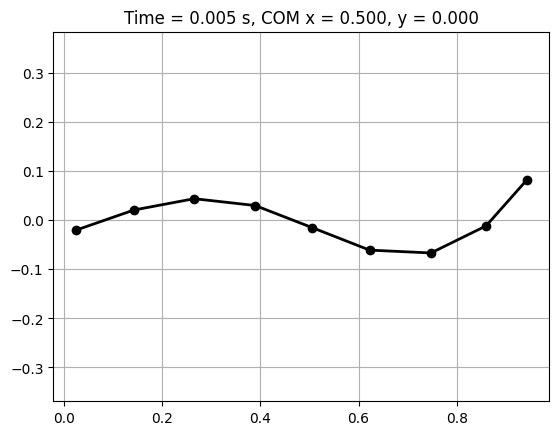

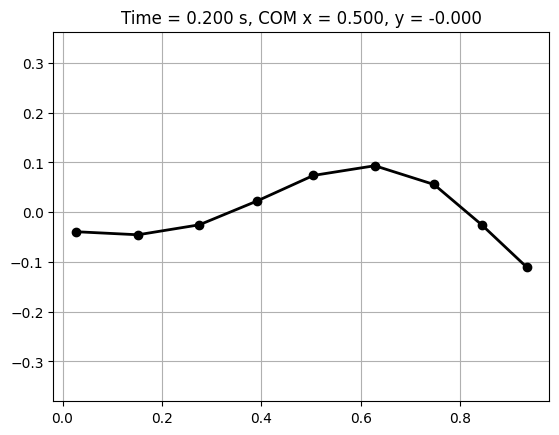

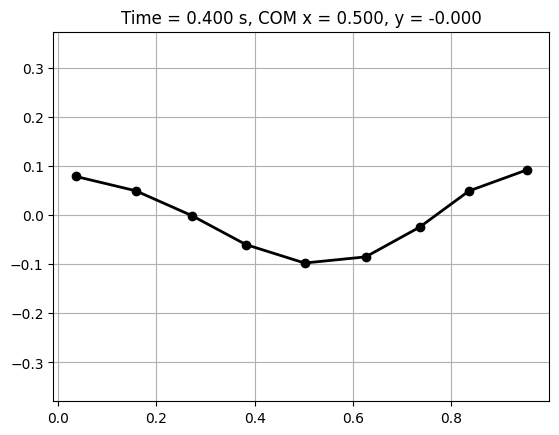

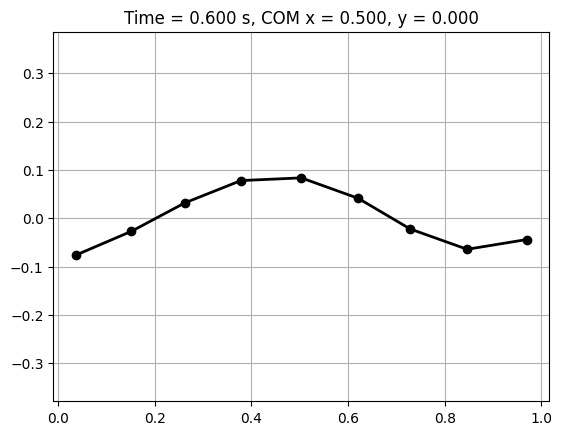

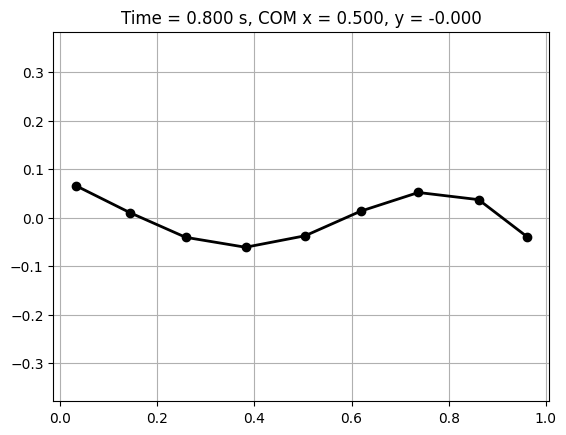

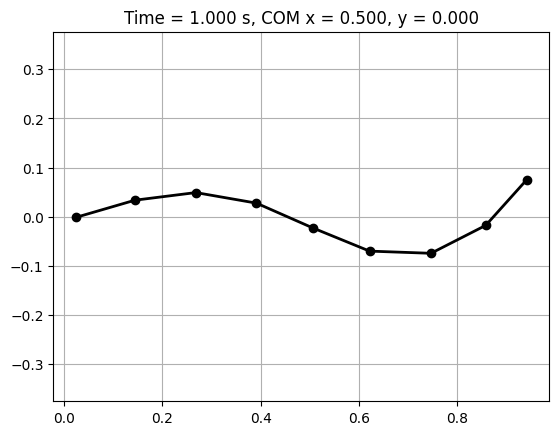

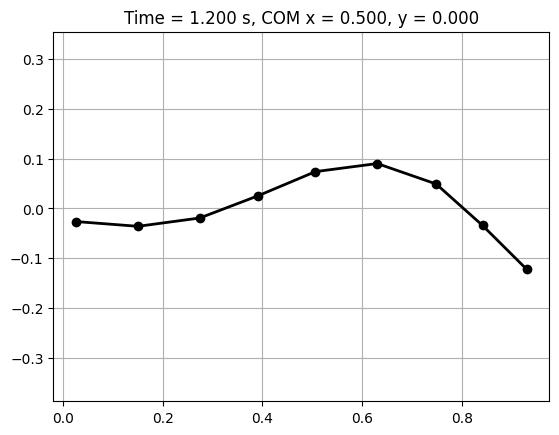

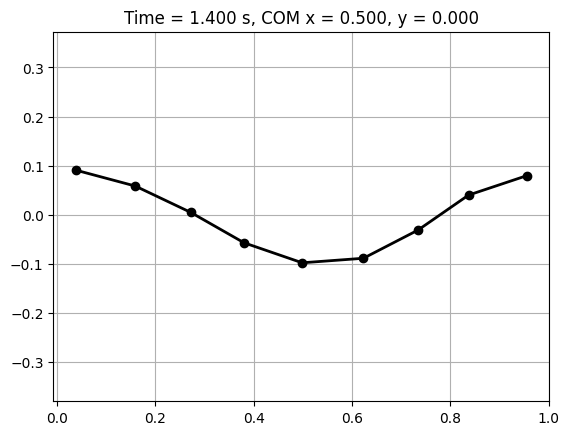

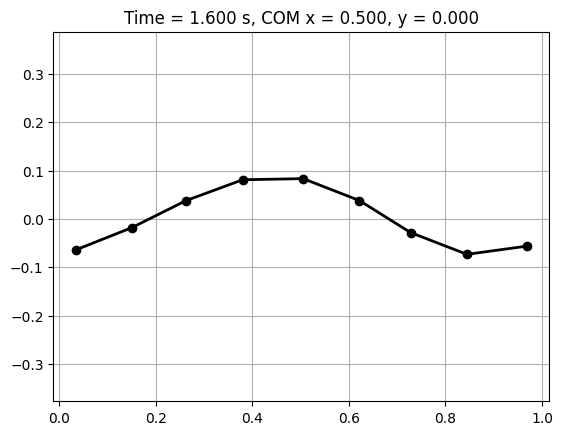

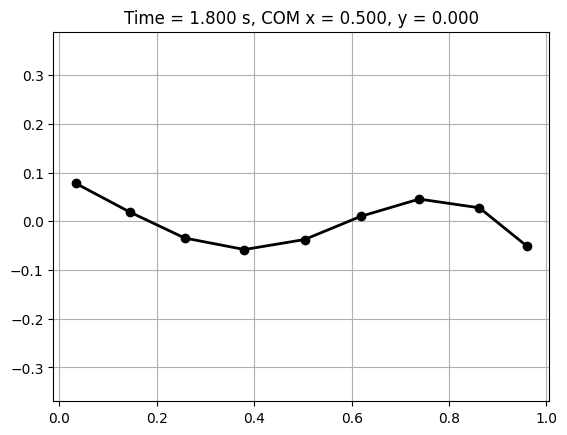

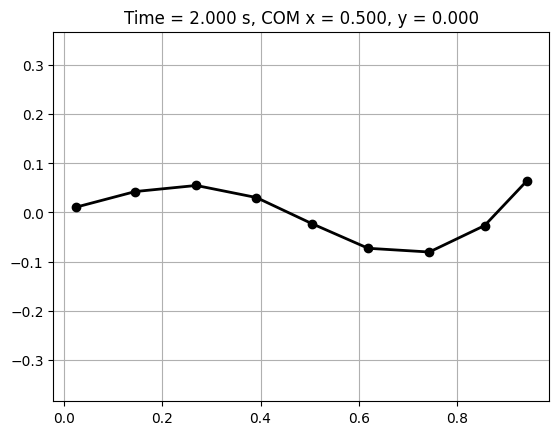

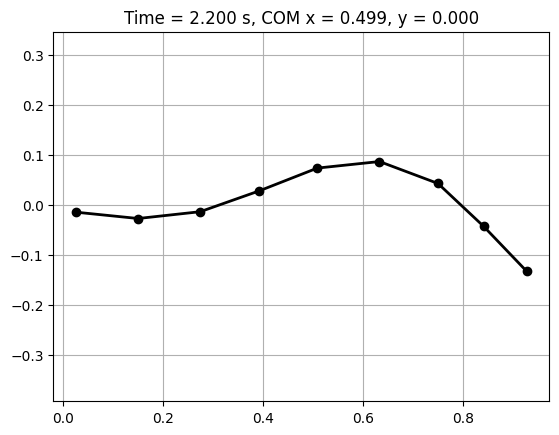

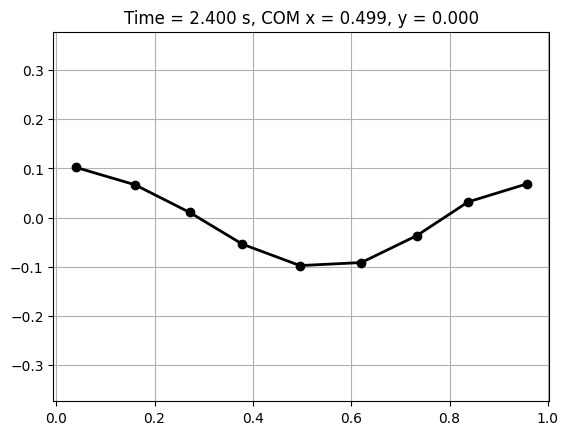

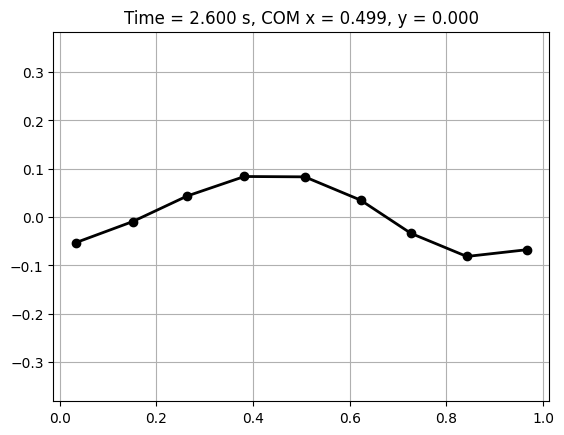

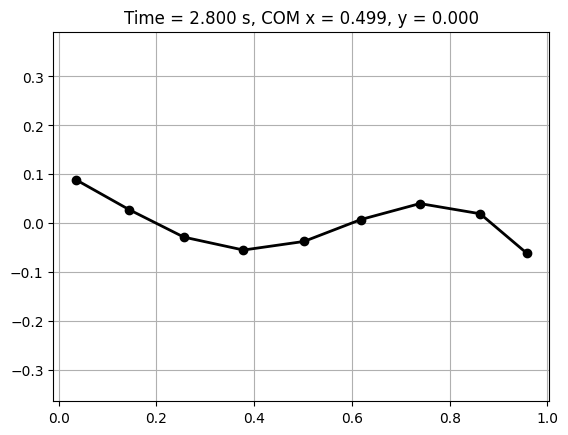

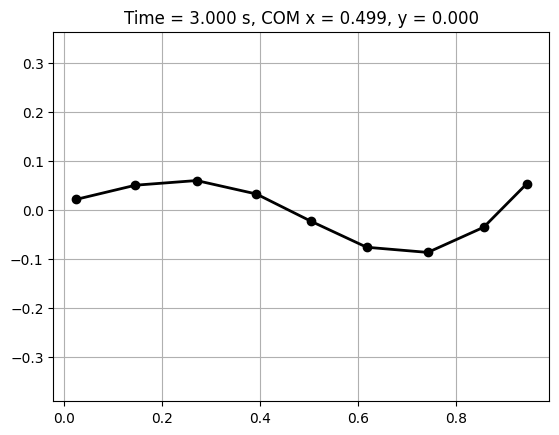

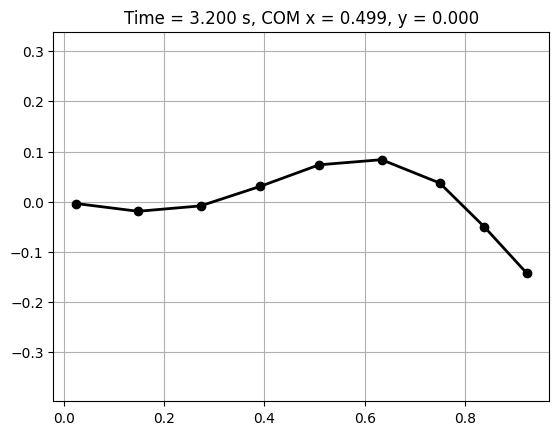

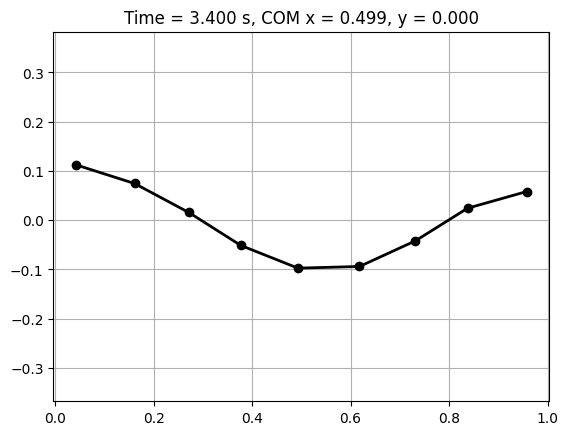

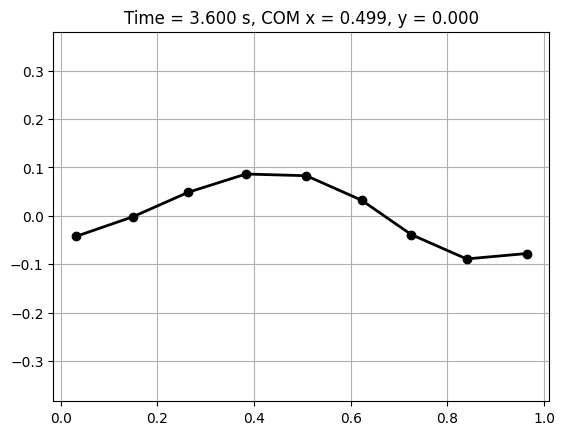

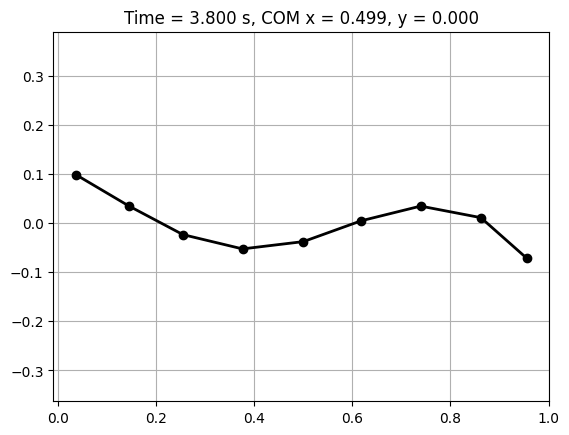

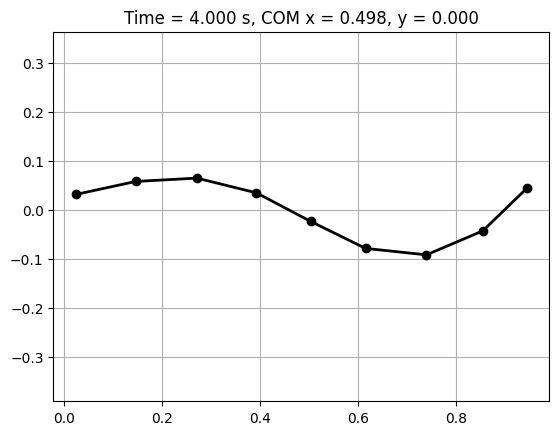

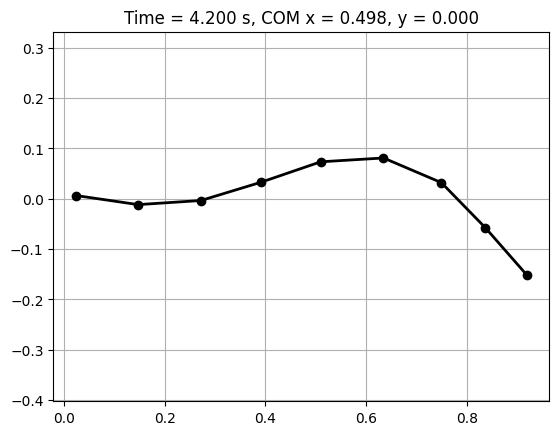

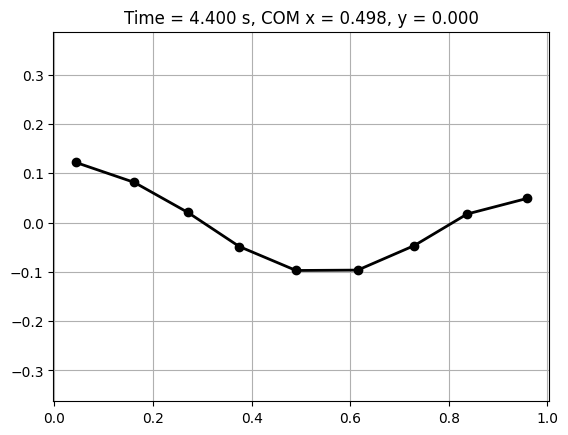

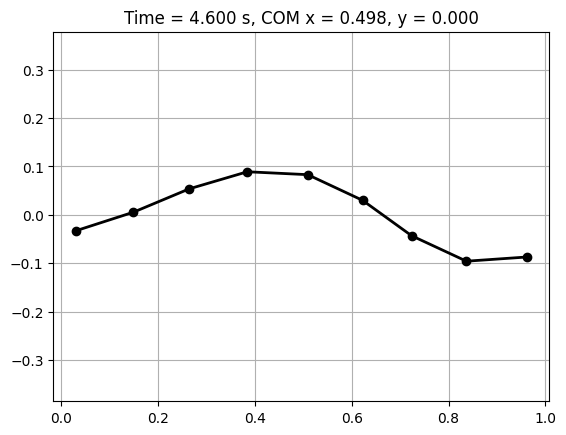

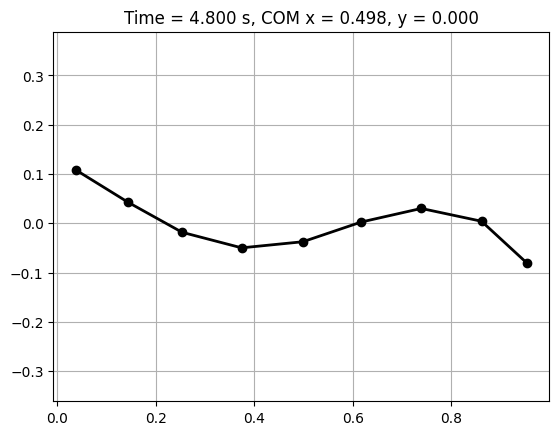

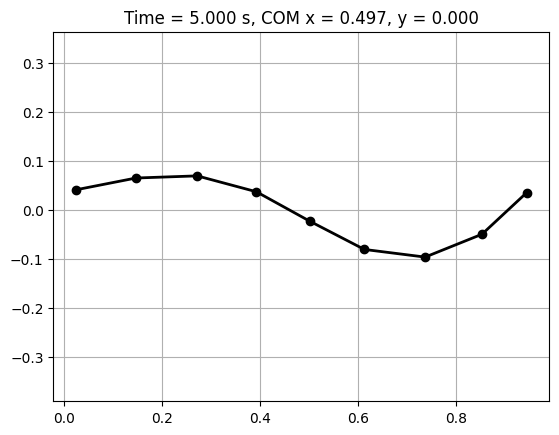

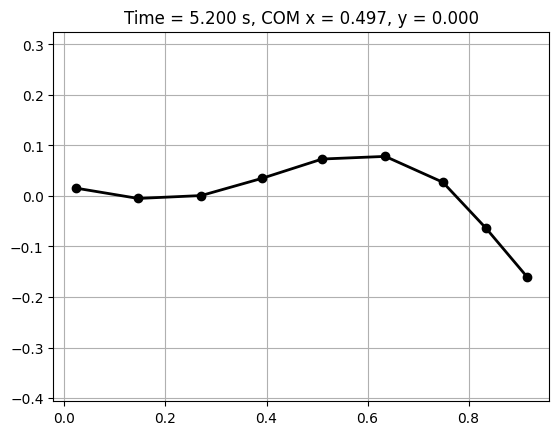

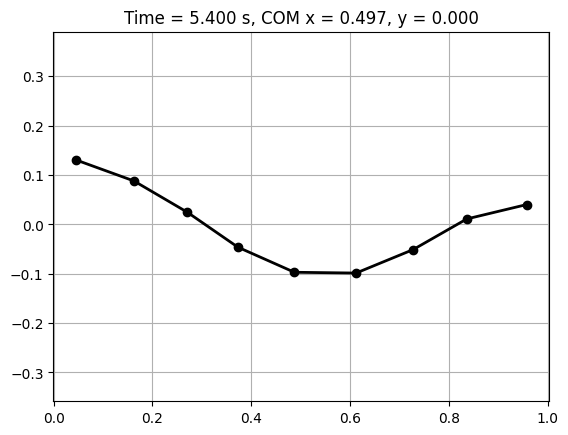

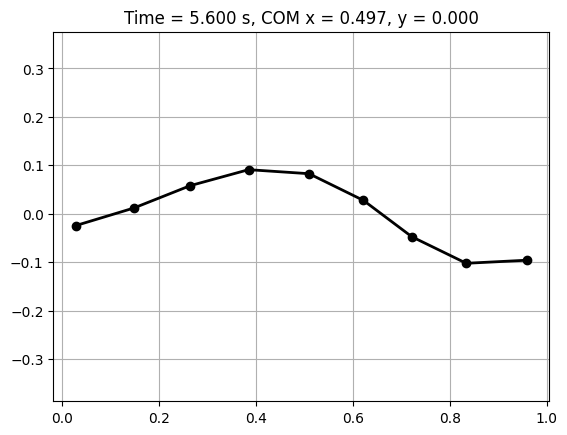

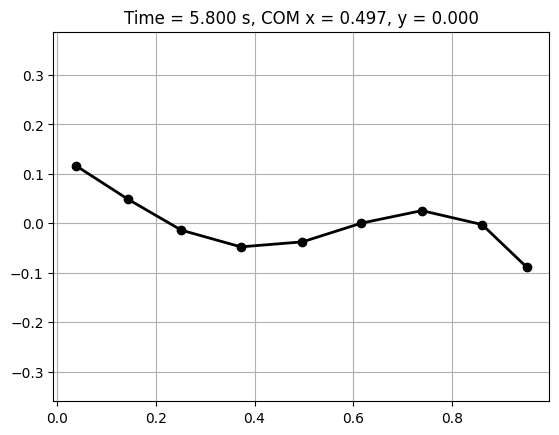

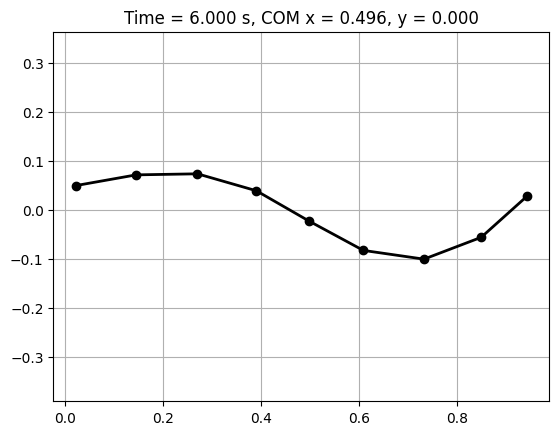

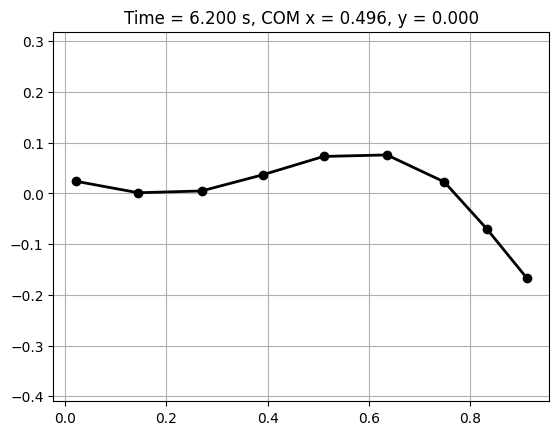

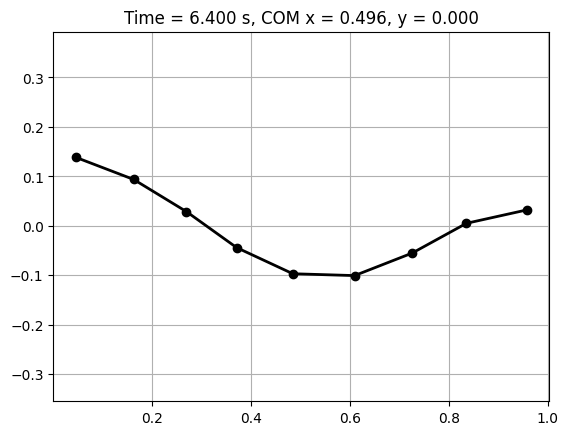

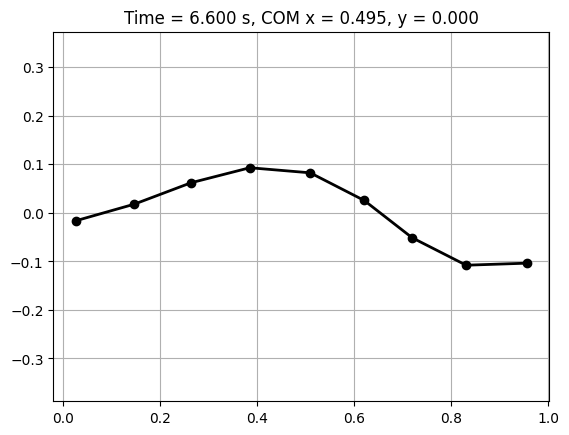

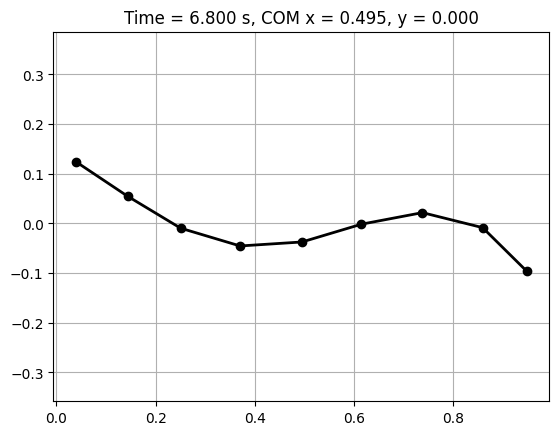

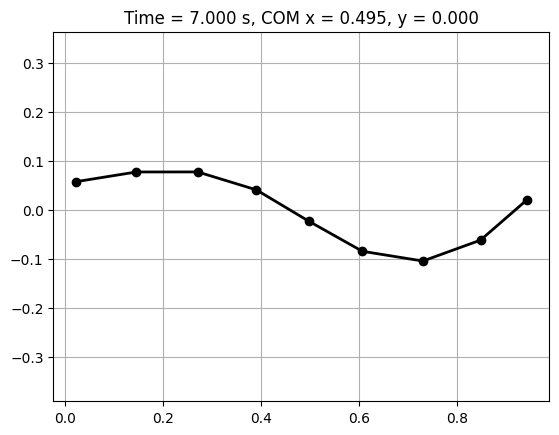

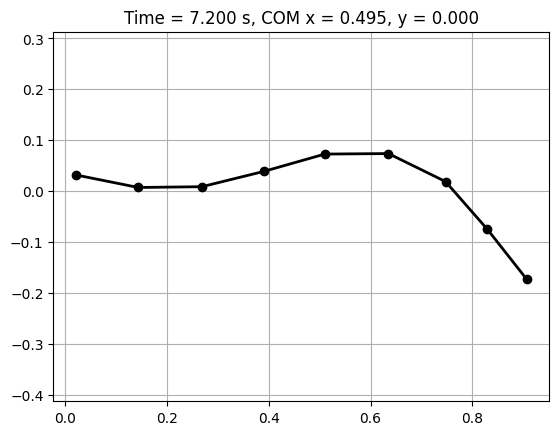

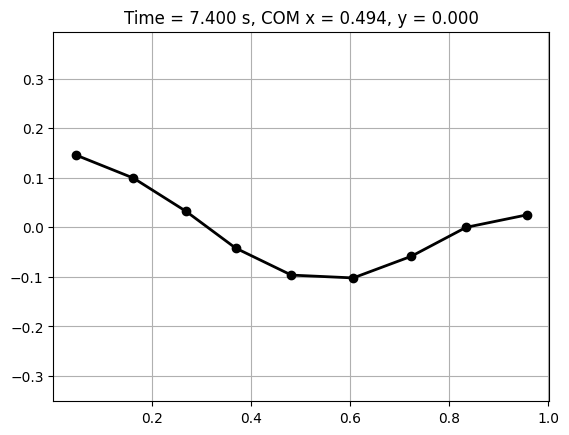

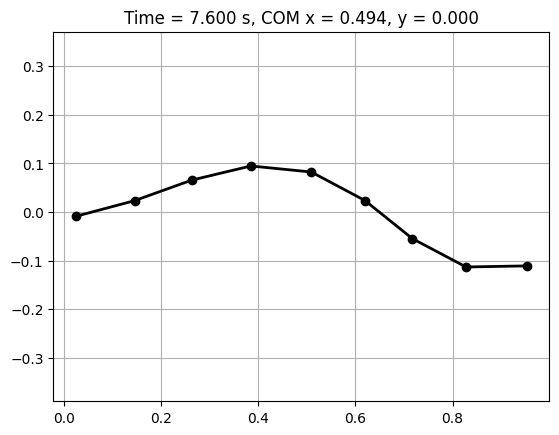

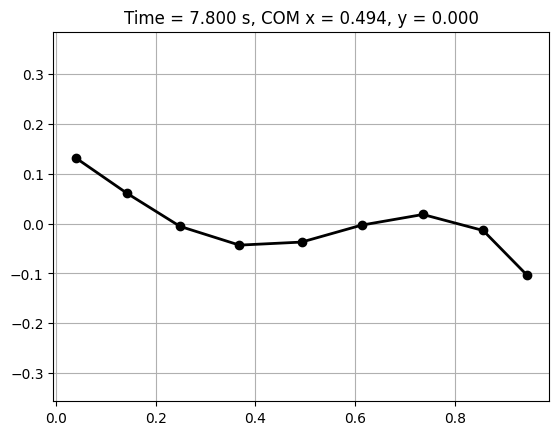

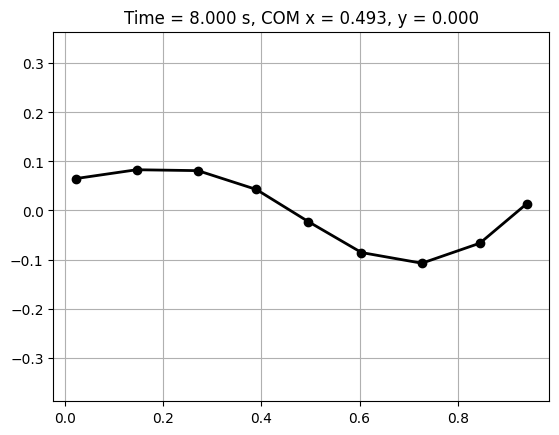

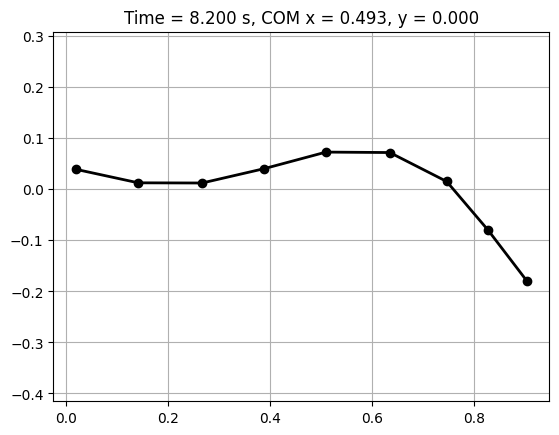

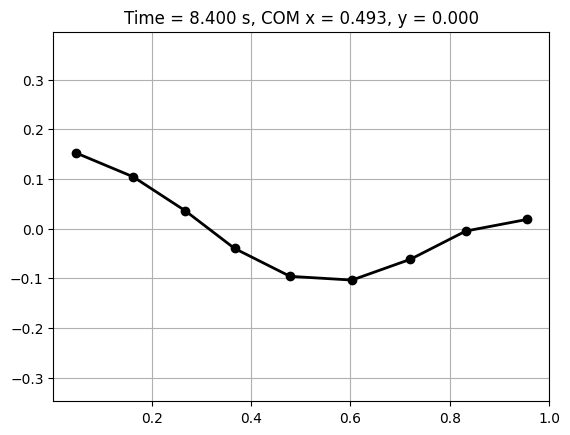

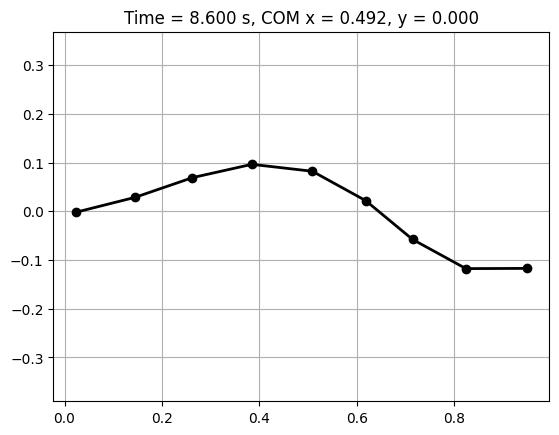

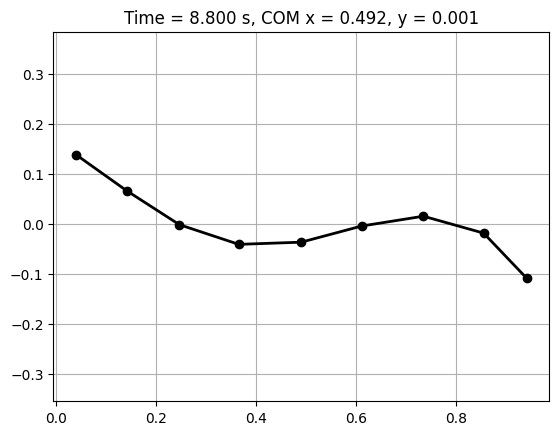

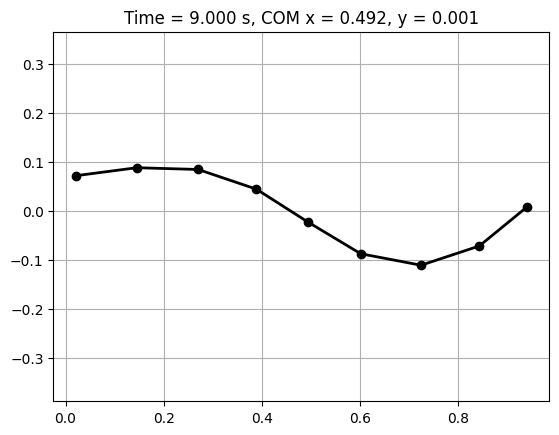

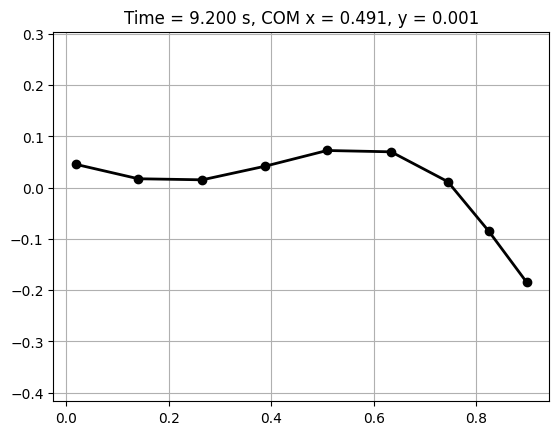

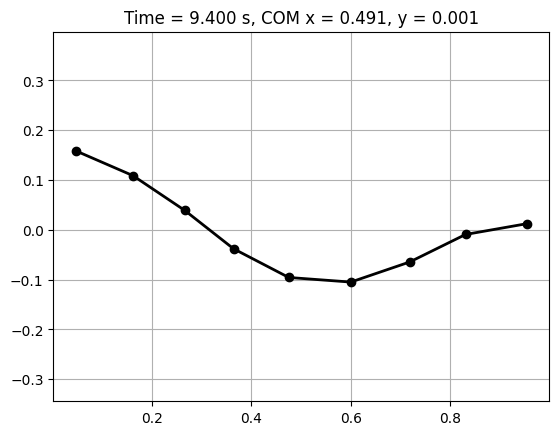

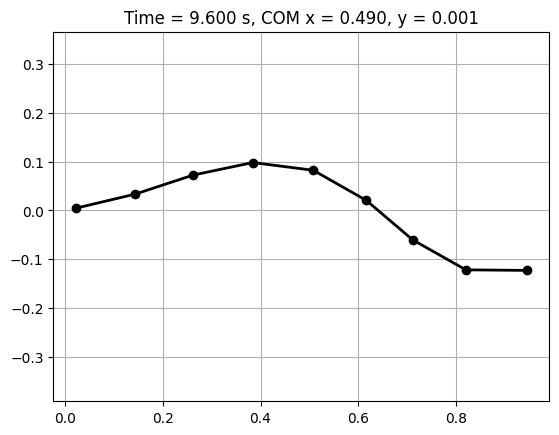

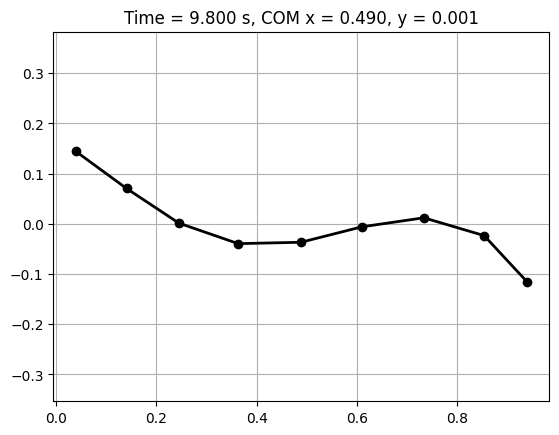

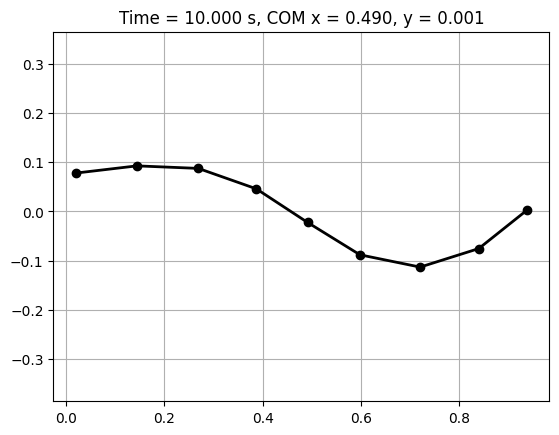

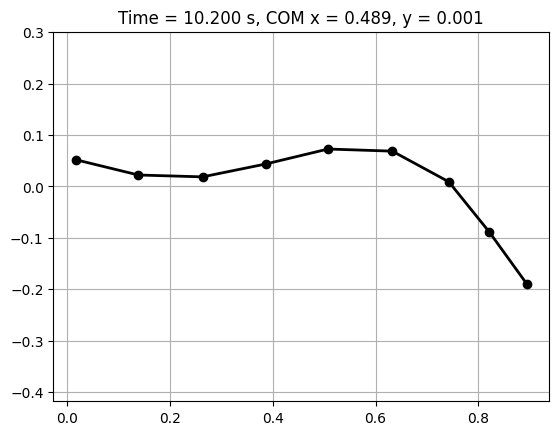

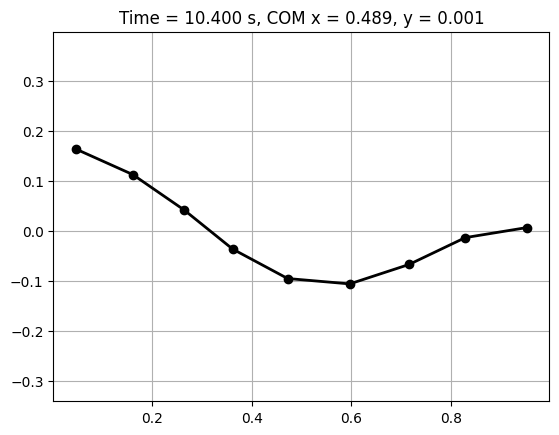

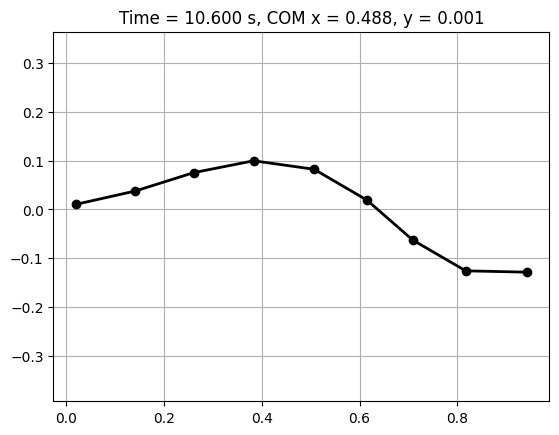

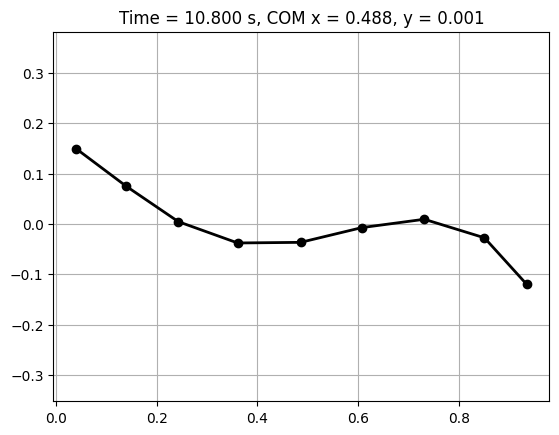

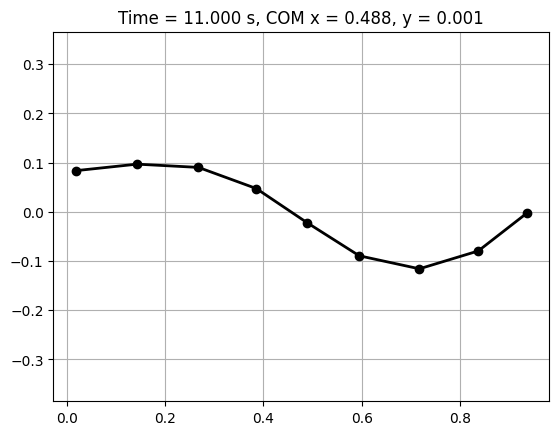

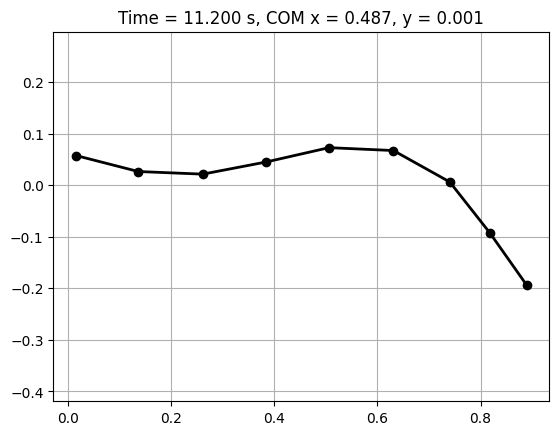

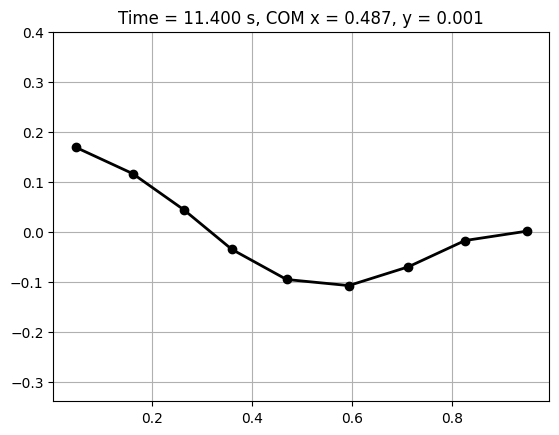

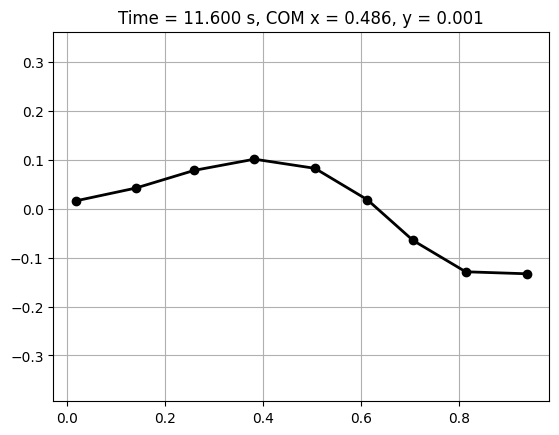

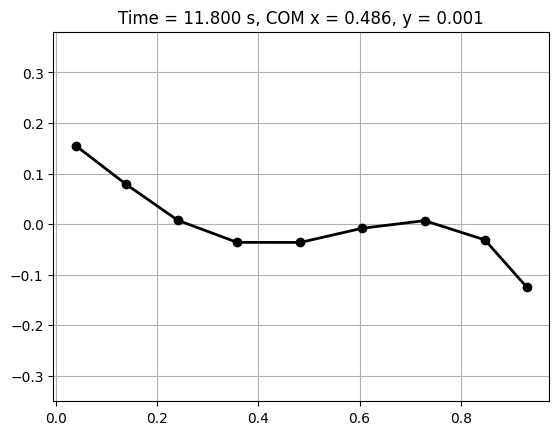

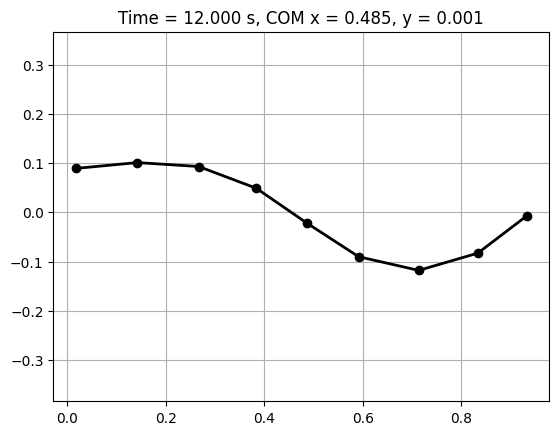

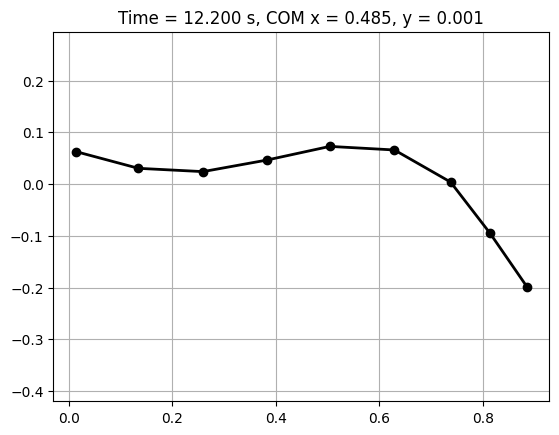

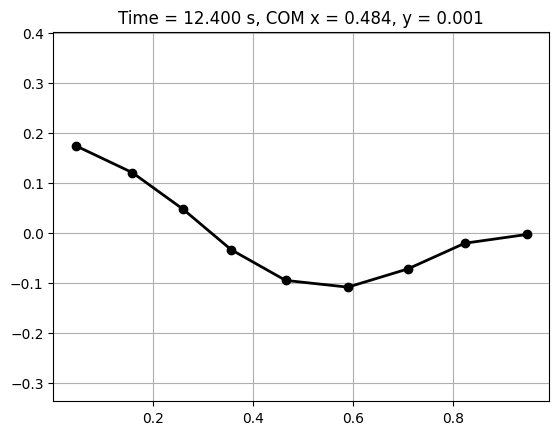

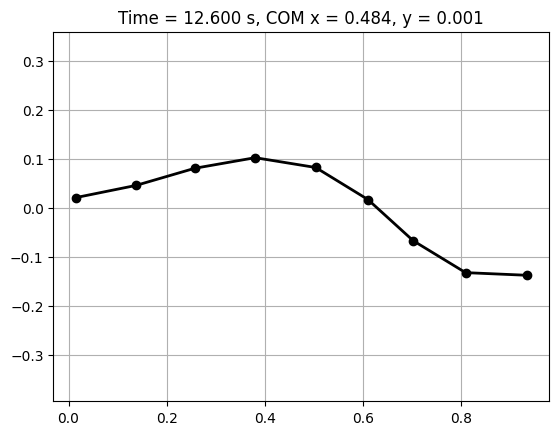

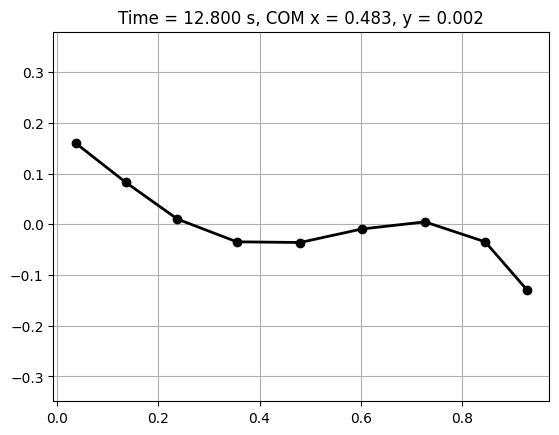

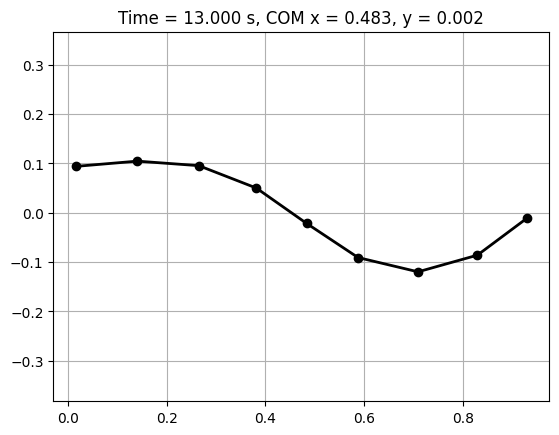

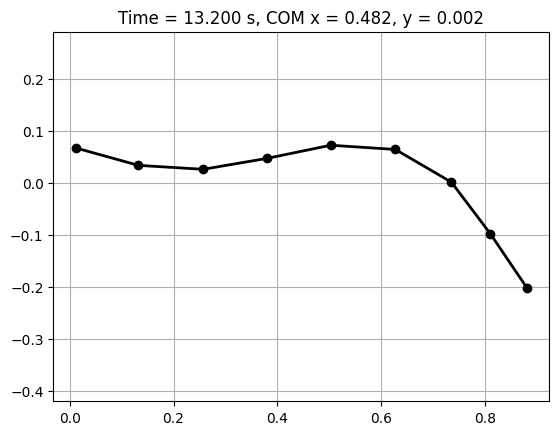

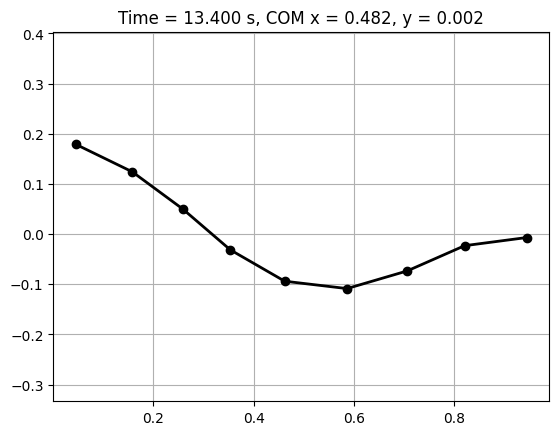

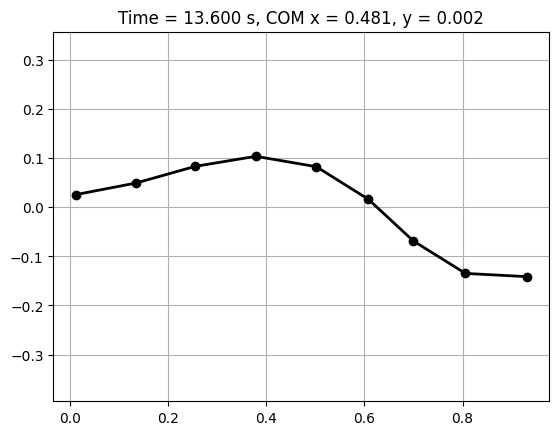

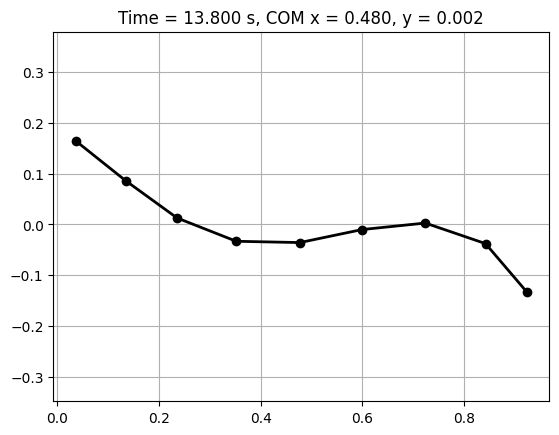

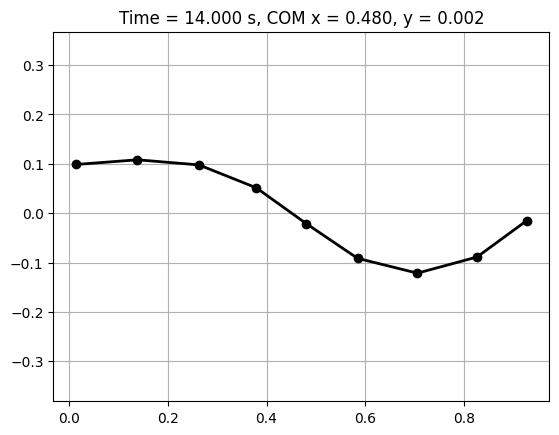

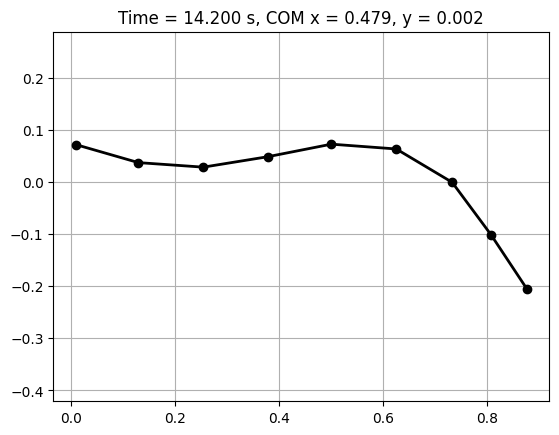

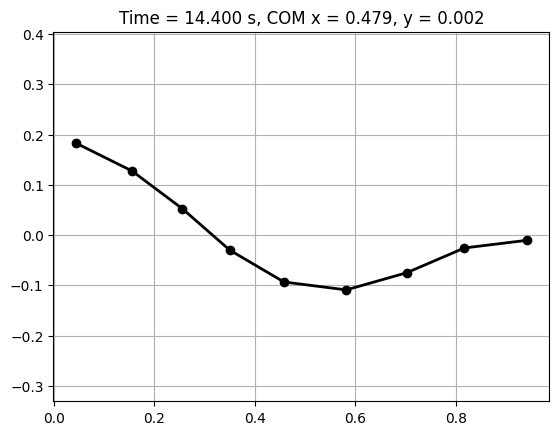

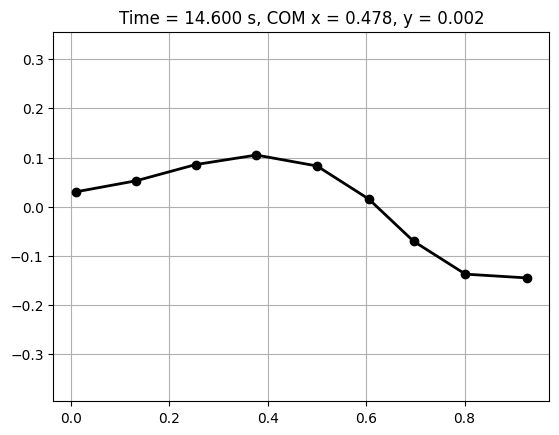

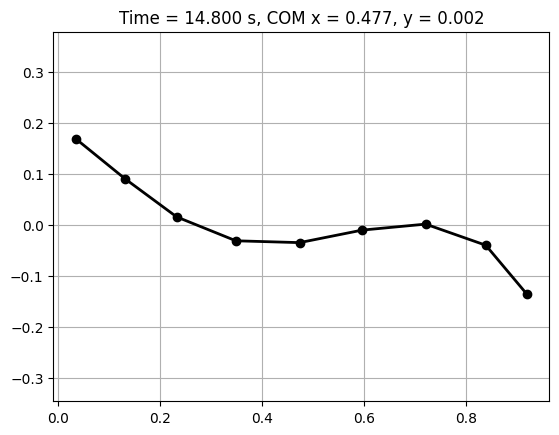

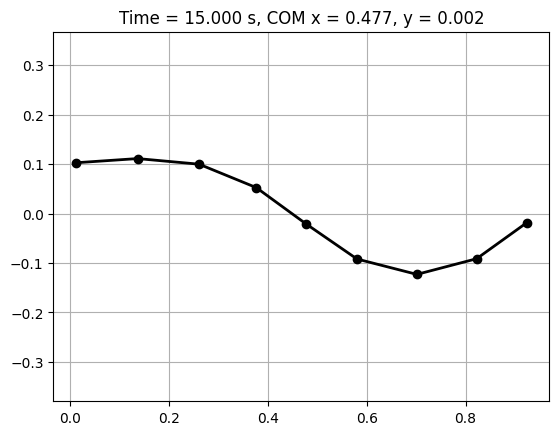

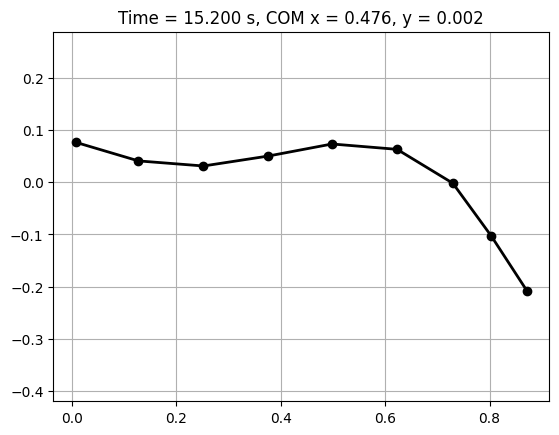

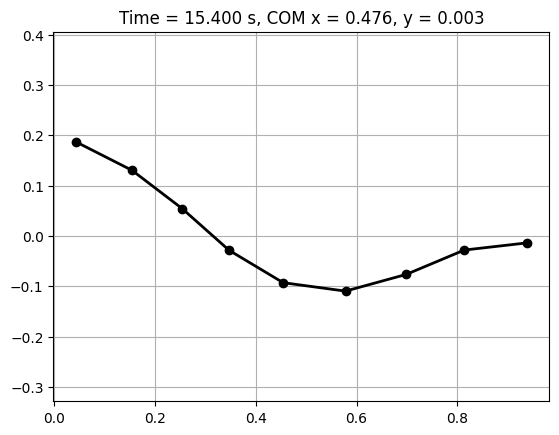

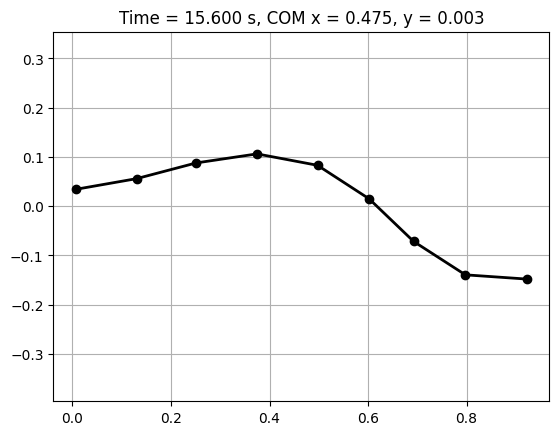

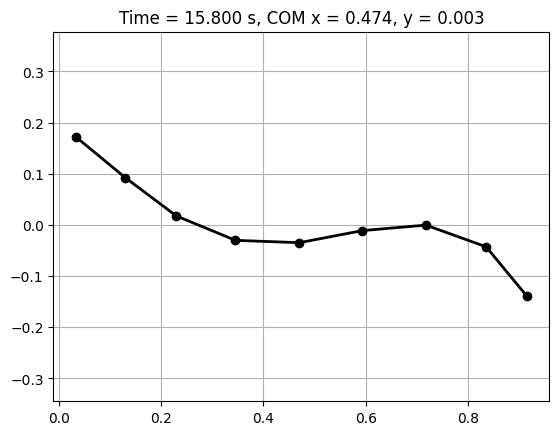

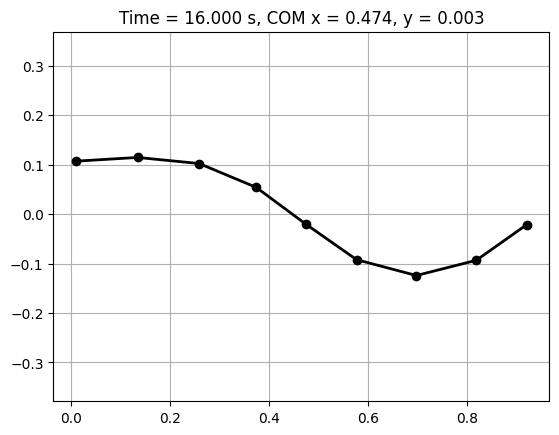

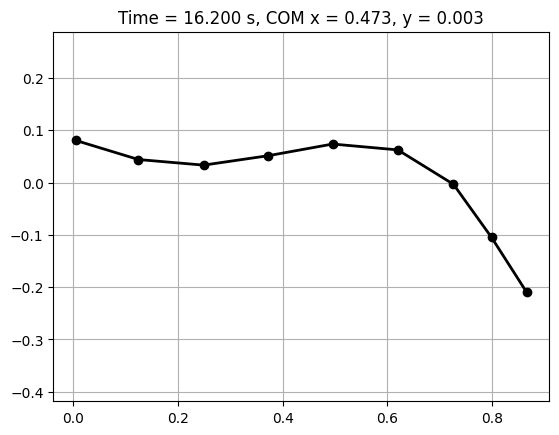

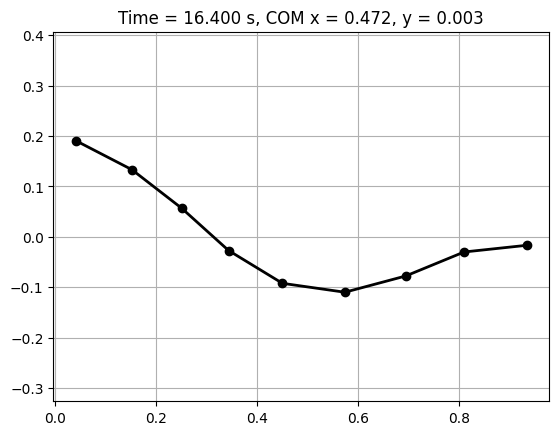

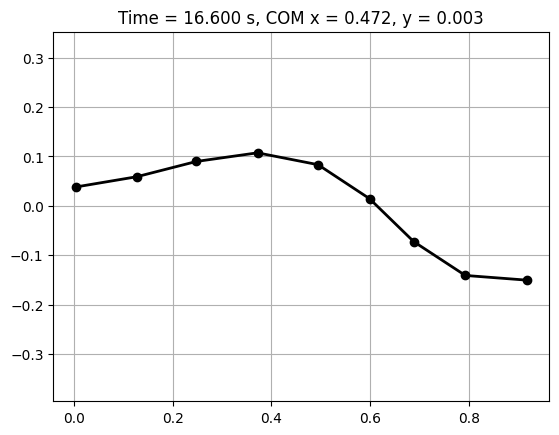

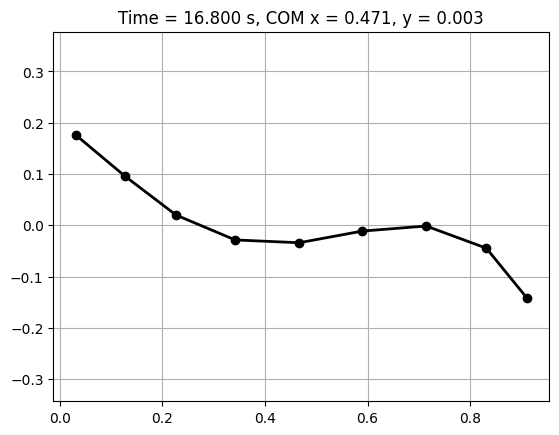

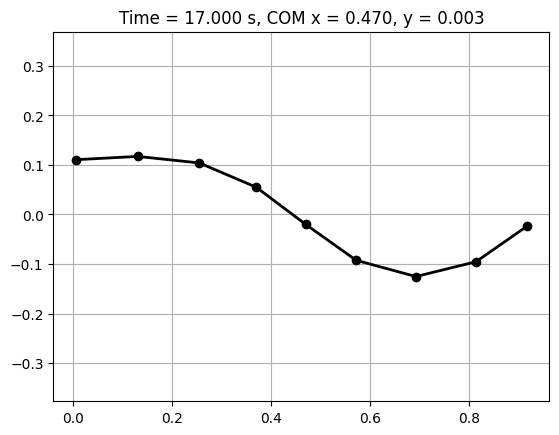

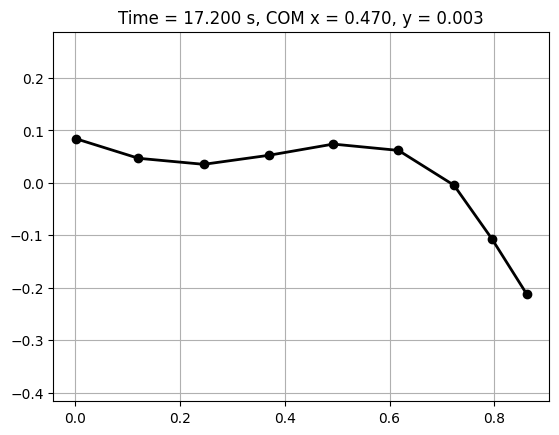

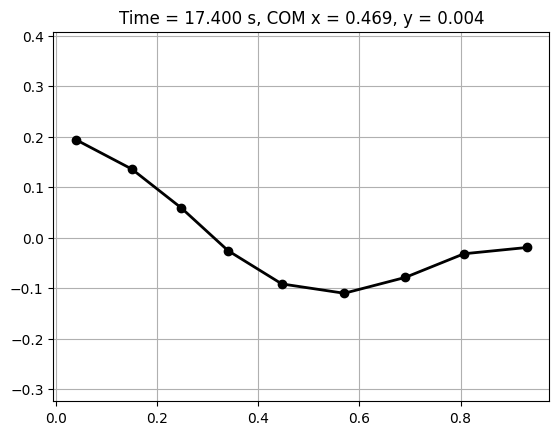

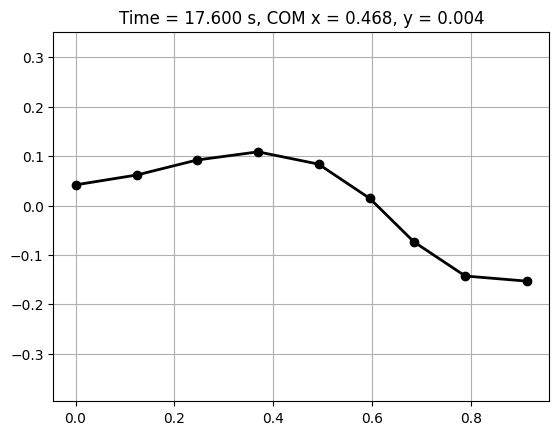

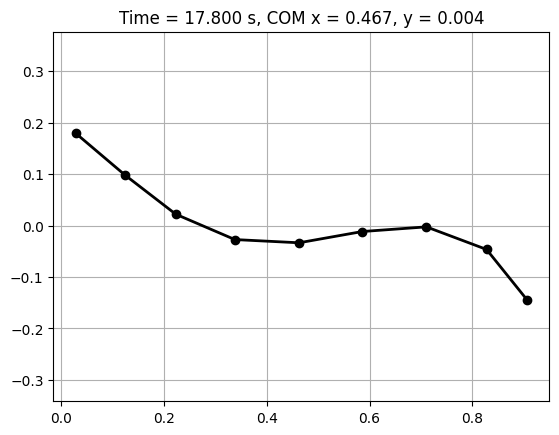

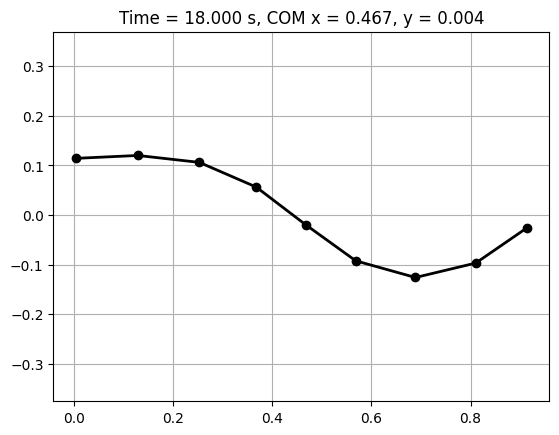

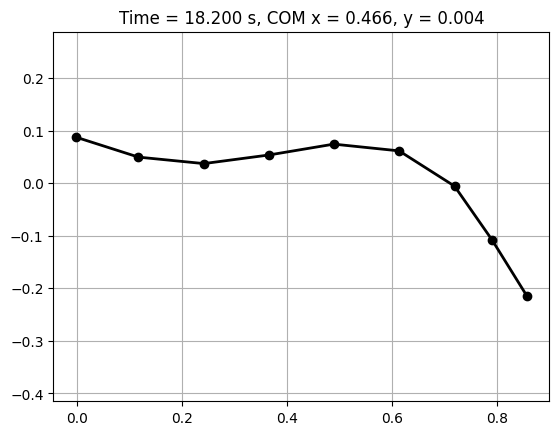

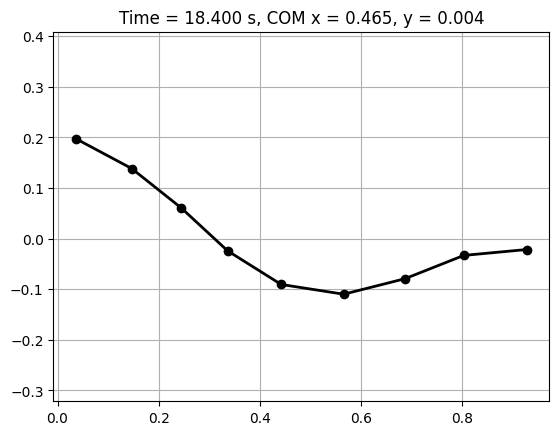

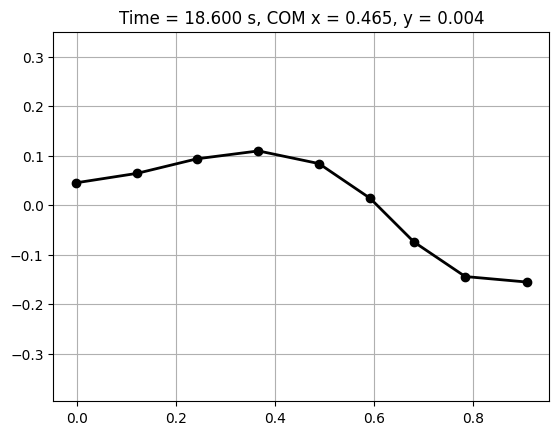

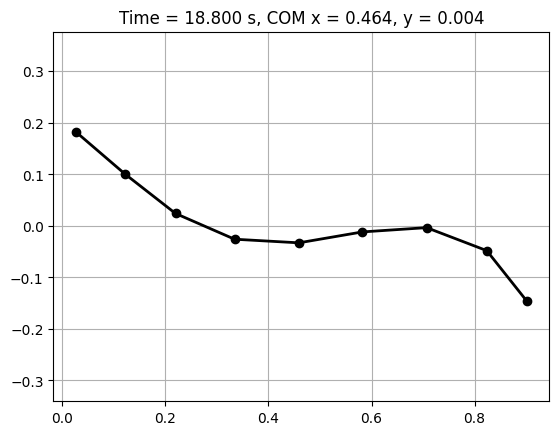

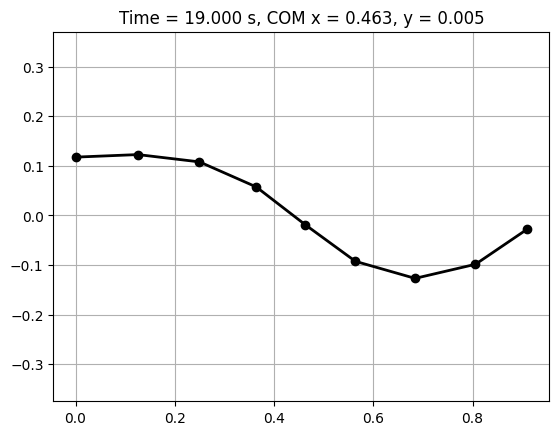

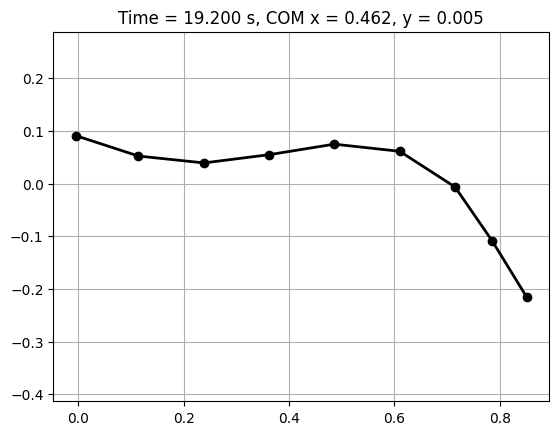

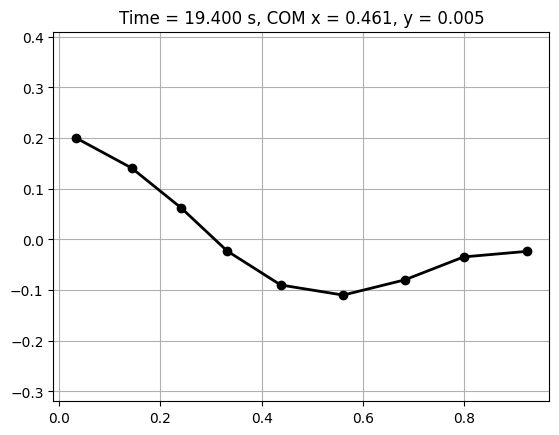

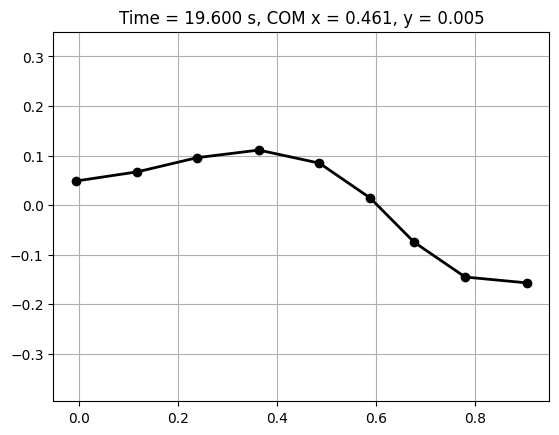

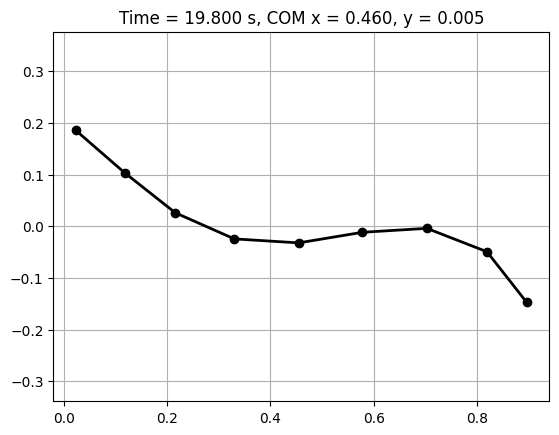

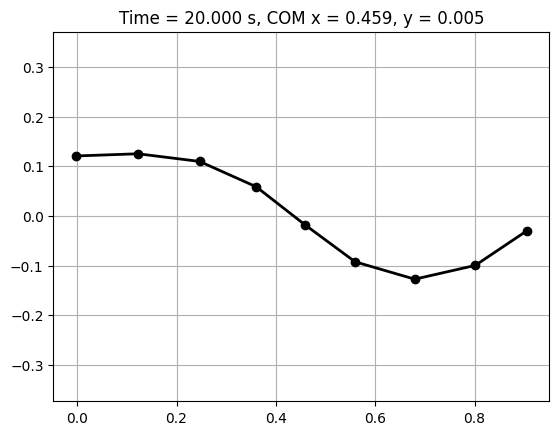

Simulation completed.


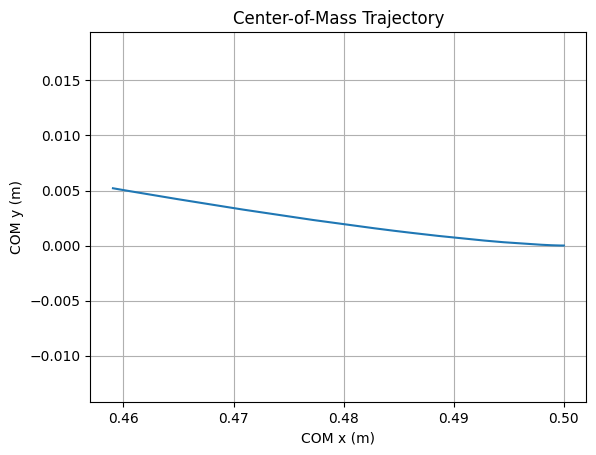

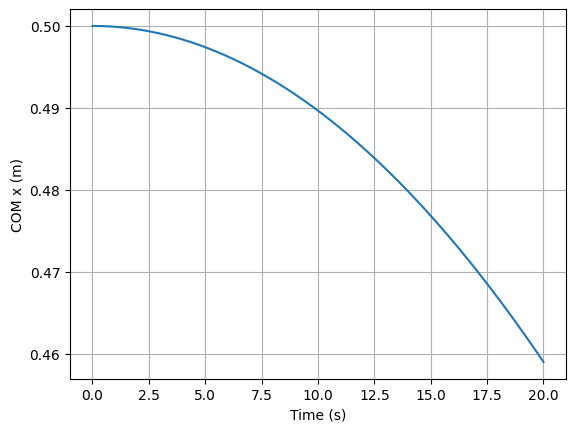

In [38]:
# ============================================
# CURVATURE-DRIVEN TAIL SIMULATION (ANISOTROPIC DRAG)
# ============================================

dt = 0.005
totalTime = 20.0
Nsteps = int(totalTime / dt)
ctime = 0.0

# No gravity – focus on swimming
W[:] = 0.0

# Curvature actuation parameters
kappa_amp = 0.6         # main curvature amplitude
f_act = 2.0             # actuation frequency (Hz)
omega = 2*np.pi*f_act
k_wave = 2*np.pi / RodLength   # spatial wave number

ndof = 2*nv
free_index = np.arange(ndof)   # all DOFs free → fish can translate/rotate

# Initial straight rod
q0 = np.zeros(ndof)
for c in range(nv):
    q0[2*c]   = c * deltaL
    q0[2*c+1] = 0.0
u0 = np.zeros_like(q0)

midNode = (nv+1)//2
time_hist  = []
mid_y_hist = []
tip_y_hist = []
com_x_hist = []
com_y_hist = []

# NEW: store horizontal motion of head and middle node
head_x_hist = []
mid_x_hist  = []

print("Starting curvature-driven tail simulation...")

for step in range(1, Nsteps+1):

    # --- Anisotropic drag matrix based on current shape q0 ---
    C = build_C_anisotropic(
        q0, nv, deltaL,
        visc_par, visc_perp
    )

    # Implicit step: inertia + elasticity + viscous drag
    q_new, u_new, flag = objfun(
        q0, u0,                # q_old, u_old
        dt, tol, maximum_iter,
        m, mMat,               # inertia
        EI, EA,                # elastic stiffness
        W, C,                  # external forces / damping
        deltaL,
        free_index,
        ctime,                 # current time t
        kappa_amp, omega, k_wave
    )

    if flag < 0:
        print("Convergence failure at step", step)
        break

    ctime += dt
    q0 = q_new.copy()
    u0 = u_new.copy()

    # Extract geometry
    x_arr = q_new[0::2]
    y_arr = q_new[1::2]

    # Track mid, tip, and center-of-mass position
    y_mid = q_new[2*(midNode-1)+1]
    y_tip = q_new[2*(nv-1)+1]
    com_x = np.mean(x_arr)
    com_y = np.mean(y_arr)

    # NEW: horizontal positions of head and middle node
    x_head = q_new[0]
    x_mid  = q_new[2*(midNode-1)]

    time_hist.append(ctime)
    mid_y_hist.append(y_mid)
    tip_y_hist.append(y_tip)
    com_x_hist.append(com_x)
    com_y_hist.append(com_y)

    head_x_hist.append(x_head)
    mid_x_hist.append(x_mid)

    if step == 1 or step % 40 == 0 or step == Nsteps:
        plt.figure(1)
        plt.clf()
        plt.plot(x_arr, y_arr, 'k-o', linewidth=2)
        plt.title(f"Time = {ctime:.3f} s, COM x = {com_x:.3f}, y = {com_y:.3f}")
        plt.axis('equal')
        plt.grid(True)
        plt.pause(0.001)

print("Simulation completed.")

# Optional: COM trajectory
plt.figure()
plt.plot(com_x_hist, com_y_hist, '-')
plt.xlabel("COM x (m)")
plt.ylabel("COM y (m)")
plt.title("Center-of-Mass Trajectory")
plt.grid(True)
plt.axis('equal')
plt.show()

plt.figure()
plt.plot(time_hist, com_x_hist, '-')
plt.xlabel("Time (s)")
plt.ylabel("COM x (m)")
plt.grid(True)
plt.show()


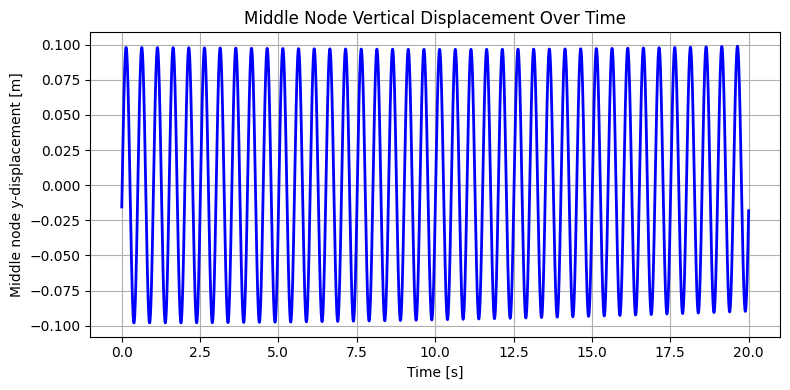

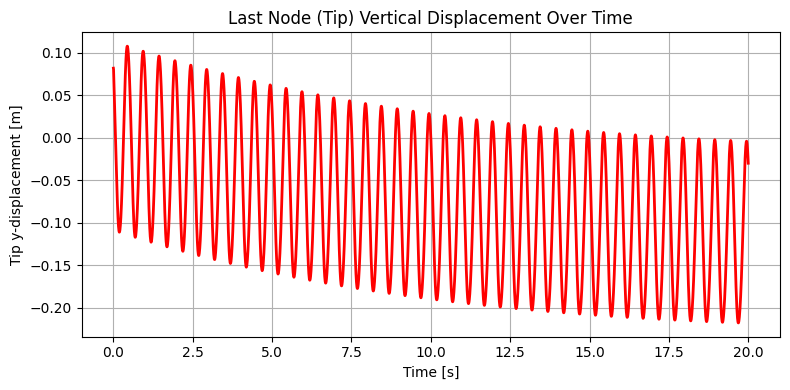

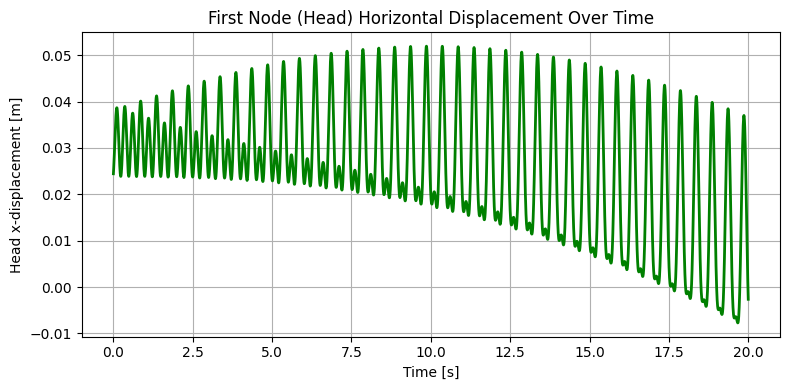

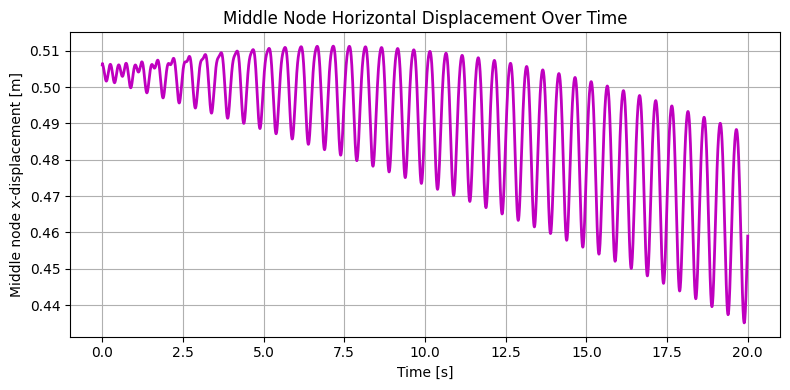

In [39]:
# ============================================
# MOVEMENT DIAGRAMS: MIDDLE / TIP (Y) & HEAD / MIDDLE (X)
# ============================================

time_hist   = np.array(time_hist)
mid_y_hist  = np.array(mid_y_hist)
tip_y_hist  = np.array(tip_y_hist)
mid_x_hist  = np.array(mid_x_hist)
head_x_hist = np.array(head_x_hist)

# 1) Middle node y-displacement vs time
plt.figure(figsize=(8,4))
plt.plot(time_hist, mid_y_hist, 'b-', linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Middle node y-displacement [m]")
plt.title("Middle Node Vertical Displacement Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Tip (last node) y-displacement vs time
plt.figure(figsize=(8,4))
plt.plot(time_hist, tip_y_hist, 'r-', linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Tip y-displacement [m]")
plt.title("Last Node (Tip) Vertical Displacement Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) First node (head) x-displacement vs time
plt.figure(figsize=(8,4))
plt.plot(time_hist, head_x_hist, 'g-', linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Head x-displacement [m]")
plt.title("First Node (Head) Horizontal Displacement Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Middle node x-displacement vs time
plt.figure(figsize=(8,4))
plt.plot(time_hist, mid_x_hist, 'm-', linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Middle node x-displacement [m]")
plt.title("Middle Node Horizontal Displacement Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


# Functions for sweeping and implementing Newmark-Beta

In [40]:
# ============================================================
# NEW SECTION: Newmark-β Integrator, Parameter Sweeps, Media Study
# ============================================================

def objfun_newmark(q_old, u_old, a_old, dt, tol, maximum_iter,
                   m, mMat,          # inertia
                   EI, EA,           # elastic stiffness
                   W, C,             # external forces / damping
                   deltaL,
                   free_index,
                   t,                # current time
                   kappa_amp, omega, k_wave,
                   beta=0.25, gamma=0.5):
    """
    Implicit Newmark-β step (β=0.5, γ=0.5 by default).

    Unknown: q_new (positions at n+1).
    Velocities and accelerations at n+1 are given by:
        q_new = q_pred + β dt^2 a_new
        v_new = v_pred + γ dt a_new
    where q_pred, v_pred depend on (q_old, u_old, a_old).
    We solve the residual:
        M a_new - F_elastic(q_new) - Fv(v_new) - W = 0
    via Newton iterations in q_new.
    """

    ndof = q_old.size

    # --- Newmark predictors ---
    # q_pred, v_pred are "kinematic prediction" from (q_old, u_old, a_old)
    q_pred = q_old + dt * u_old + 0.5 * dt**2 * (1.0 - 2.0 * beta) * a_old
    v_pred = u_old + dt * (1.0 - gamma) * a_old

    # Initial guess for q_new
    q_new = q_old.copy()

    iter_count = 0
    error = tol * 10.0
    flag = 1

    # Precompute scaling factors
    inv_beta_dt2 = 1.0 / (beta * dt**2)
    gamma_over_beta_dt = gamma / (beta * dt)

    while error > tol:
        # --- Kinematics at new time ---
        a_new = (q_new - q_pred) * inv_beta_dt2
        v_new = v_pred + gamma * dt * a_new

        # --- Inertia term ---
        F_inertia = mMat @ a_new
        J_inertia = mMat * inv_beta_dt2

        # --- Elastic forces ---
        Fs, Js = getFs(q_new, EA, deltaL)
        Fb, Jb = getFb(q_new, EI, deltaL, t, kappa_amp, omega, k_wave)
        F_elastic = Fs + Fb
        J_elastic = Js + Jb

        # --- Viscous forces ---
        Fv = - C @ v_new
        # dv/dq = gamma/(beta*dt) * I  -> Jv = -C * (gamma/(beta*dt))
        Jv = - C * gamma_over_beta_dt

        # --- Residual and Jacobian ---
        # Equation of motion: M a_new - F_elastic - Fv - W = 0
        f = F_inertia - F_elastic - Fv - W
        J = J_inertia - J_elastic - Jv

        # Restrict to free DOFs
        f_free = f[free_index]
        J_free = J[np.ix_(free_index, free_index)]

        # Newton step
        dq_free = np.linalg.solve(J_free, f_free)
        q_new[free_index] -= dq_free

        error = np.linalg.norm(f_free)
        iter_count += 1
        if iter_count > maximum_iter:
            flag = -1
            print("Newmark-β: maximum iterations reached.")
            break

    # Final a_new, v_new consistent with q_new
    a_new = (q_new - q_pred) * inv_beta_dt2
    v_new = v_pred + gamma * dt * a_new

    return q_new, v_new, a_new, flag


# ------------------------------------------------------------
# Helper to run one simulation (Euler or Newmark) and return metrics
# ------------------------------------------------------------

def run_tail_simulation(integrator="euler",
                        medium="water",
                        kappa_amp=1.0,
                        totalTime=1.0,
                        dt=0.005,
                        f_act=2.0,
                        k_wave=None):
    """
    Run a single tail simulation and return basic metrics.

    integrator: "euler" (uses existing objfun) or "newmark"
    medium:     "water", "glycerol", "air" (sets viscosity)
    kappa_amp:  curvature amplitude
    totalTime:  total simulation time
    dt:         time step
    f_act:      actuation frequency
    k_wave:     spatial wavenumber; if None, use 2π / RodLength

    Returns:
      results dict with fields:
        'time': time array
        'com_x': COM x history
        'com_y': COM y history
        'net_dx': com_x[-1] - com_x[0]
        'max_abs_y': max |com_y|
        'label': text label
    """

    global W  # we will temporarily overwrite gravity

    # --- Medium properties (viscosity only; density handled via m) ---
    # dynamic viscosity (approximate)
    if medium.lower() == "water":
        visc_local = 1.0e-3
    elif medium.lower() == "glycerol":
        visc_local = 1.0     # much more viscous
    elif medium.lower() == "air":
        visc_local = 1.8e-5
    else:
        # default to water-like if unknown
        visc_local = 1.0e-3

    # anisotropic drag ratio C_perp / C_par
    drag_ratio = 5.0

    # actuation frequency & wave number
    omega = 2.0 * np.pi * f_act
    if k_wave is None:
        k_wave = 2.0 * np.pi / RodLength

    ndof = 2 * nv
    free_index = np.arange(ndof)

    # disable gravity for swimming
    W_backup = W.copy()
    W[:] = 0.0

    # initial conditions: straight rod, zero velocity & acceleration
    q = np.zeros(ndof)
    for c in range(nv):
        q[2*c]   = c * deltaL
        q[2*c+1] = 0.0

    u = np.zeros_like(q)   # velocity
    a = np.zeros_like(q)   # acceleration (for Newmark)

    # time loop
    Nsteps = int(totalTime / dt)
    ctime = 0.0

    com_x_hist = []
    com_y_hist = []
    time_hist  = []

    for step in range(Nsteps):
        # build anisotropic drag matrix for current configuration
        equiv_radius = np.sqrt(A / np.pi)
        visc_par  = 6.0 * np.pi * visc_local * equiv_radius
        visc_perp = drag_ratio * visc_par

        C_local = build_C_anisotropic(q, nv, deltaL, visc_par, visc_perp)

        if integrator.lower() == "euler":
            # use your existing implicit Euler objfun
            q_new, u_new, flag = objfun(
                q, u,
                dt, tol, maximum_iter,
                m, mMat,
                EI, EA,
                W, C_local,
                deltaL,
                free_index,
                ctime,
                kappa_amp, omega, k_wave
            )
            a_new = (u_new - u) / dt

        elif integrator.lower() == "newmark":
            q_new, u_new, a_new, flag = objfun_newmark(
                q, u, a,
                dt, tol, maximum_iter,
                m, mMat,
                EI, EA,
                W, C_local,
                deltaL,
                free_index,
                ctime,
                kappa_amp, omega, k_wave,
                beta=0.5, gamma=0.5
            )
        else:
            raise ValueError("integrator must be 'euler' or 'newmark'.")

        if flag < 0:
            # stop on convergence failure
            break

        ctime += dt
        q = q_new
        u = u_new
        a = a_new

        x_arr = q[0::2]
        y_arr = q[1::2]
        com_x = np.mean(x_arr)
        com_y = np.mean(y_arr)

        com_x_hist.append(com_x)
        com_y_hist.append(com_y)
        time_hist.append(ctime)

    # restore gravity
    W[:] = W_backup

    com_x_hist = np.array(com_x_hist)
    com_y_hist = np.array(com_y_hist)
    time_hist  = np.array(time_hist)

    if len(com_x_hist) > 0:
        net_dx = com_x_hist[-1] - com_x_hist[0]
        max_abs_y = np.max(np.abs(com_y_hist))
    else:
        net_dx = 0.0
        max_abs_y = 0.0

    label = f"{integrator}, {medium}, kappa_amp={kappa_amp}"

    return {
        "time": time_hist,
        "com_x": com_x_hist,
        "com_y": com_y_hist,
        "net_dx": net_dx,
        "max_abs_y": max_abs_y,
        "label": label,
    }


In [41]:
# ============================================================
# FULL PLOTTING BLOCK FOR PARAMETER SWEEP RESULTS
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

def sweep_results_to_df(all_sweep_results):
    """
    Convert list of sweep result dicts into a pandas DataFrame.
    Each row corresponds to one parameter combination.
    """
    rows = []
    for res in all_sweep_results:
        row = {
            "net_dx": res["net_dx"],
            "max_abs_y": res["max_abs_y"],
            "mean_Es": res["mean_Es"],
            "mean_Eb": res["mean_Eb"],
            "mean_Ek": res["mean_Ek"],
            "mean_Pv": res["mean_Pv"],
        }
        # Add parameters from the nested dict
        for k, v in res["params"].items():
            row[k] = v
        rows.append(row)
    return pd.DataFrame(rows)


def plot_net_dx_vs_freq(df):
    """
    Plot net forward distance vs frequency for each medium and E_factor.
    """
    for med in df["medium"].unique():
        df_med = df[df["medium"] == med]
        plt.figure()
        for Efac in sorted(df_med["E_factor"].unique()):
            sub = df_med[df_med["E_factor"] == Efac]
            # Ensure sorted frequency
            sub = sub.sort_values("freq")
            plt.plot(sub["freq"], sub["net_dx"], "o-", label=f"E×{Efac}")
        plt.xlabel("Frequency f (Hz)")
        plt.ylabel("Net Δx (m)")
        plt.title(f"Net Δx vs Frequency in {med}")
        plt.grid(True)
        plt.legend()
        plt.show()


def plot_net_dx_vs_kappa(df):
    """
    Plot net forward distance vs curvature amplitude for each medium.
    """
    for med in df["medium"].unique():
        df_med = df[df["medium"] == med]
        plt.figure()
        for f in sorted(df_med["freq"].unique()):
            sub = df_med[df_med["freq"] == f]
            sub = sub.sort_values("kappa_amp")
            plt.plot(sub["kappa_amp"], sub["net_dx"], "o-",
                     label=f"f={f} Hz")
        plt.xlabel("Curvature amplitude κ_amp")
        plt.ylabel("Net Δx (m)")
        plt.title(f"Net Δx vs κ_amp in {med}")
        plt.grid(True)
        plt.legend()
        plt.show()


def plot_net_dx_vs_E(df):
    """
    Plot net forward distance vs stiffness scaling E_factor (for each medium).
    """
    for med in df["medium"].unique():
        df_med = df[df["medium"] == med]
        plt.figure()
        for kap in sorted(df_med["kappa_amp"].unique()):
            sub = df_med[df_med["kappa_amp"] == kap]
            sub = sub.sort_values("E_factor")
            plt.plot(sub["E_factor"], sub["net_dx"], "o-",
                     label=f"κ={kap}")
        plt.xlabel("Stiffness scaling E_factor")
        plt.ylabel("Net Δx (m)")
        plt.title(f"Net Δx vs E_factor in {med}")
        plt.grid(True)
        plt.legend()
        plt.show()


def plot_net_dx_by_medium(df):
    """
    Bar chart: average net Δx by medium (averaging all parameter combinations).
    """
    df_med = df.groupby("medium")["net_dx"].mean().reset_index()

    plt.figure()
    plt.bar(df_med["medium"], df_med["net_dx"])
    plt.xlabel("Medium")
    plt.ylabel("Average net Δx (m)")
    plt.title("Average Net Forward Distance by Medium")
    plt.grid(axis="y")
    plt.show()



In [42]:
def simulate_tail_case_euler(E_factor=1.0,
                             radius_factor=1.0,
                             rho_factor=1.0,
                             visc_factor=1.0,
                             medium="water",
                             kappa_amp=1.0,
                             freq=2.0,
                             drag_ratio=5.0,
                             totalTime=0.5,
                             dt=0.005):
    """
    Simulate one full case using the GENERAL implicit Euler integrator objfun.

    This version is simplified for speed: it does NOT compute energies.
    It only returns COM trajectory, net Δx, and max lateral excursion.
    """

    # Use existing global geometry parameters as baseline
    Y0        = Y
    R_outer0  = R_outer
    R_inner0  = R_inner
    rho0      = rho_metal
    RodLength_case = RodLength
    deltaL_case    = RodLength_case / (nv - 1)
    ndof      = 2 * nv
    free_index = np.arange(ndof)

    # --- Material and geometry for this case ---
    Y_case        = Y0 * E_factor
    R_outer_case  = R_outer0 * radius_factor
    R_inner_case  = R_inner0 * radius_factor

    A_case = np.pi * (R_outer_case**2 - R_inner_case**2)
    I_case = np.pi / 4.0 * (R_outer_case**4 - R_inner_case**4)

    EI_case = Y_case * I_case
    EA_case = Y_case * A_case

    rho_case   = rho0 * rho_factor
    node_mass  = rho_case * A_case * deltaL_case
    m_vec_case = np.zeros(ndof)
    for k in range(nv):
        m_vec_case[2*k]   = node_mass
        m_vec_case[2*k+1] = node_mass
    mMat_case = np.diag(m_vec_case)

    # --- Medium viscosity (base) ---
    if medium.lower() == "water":
        mu_base = 1.0e-3
    elif medium.lower() == "glycerol":
        mu_base = 1.0
    elif medium.lower() == "air":
        mu_base = 1.8e-5
    else:
        mu_base = 1.0e-3  # default water-like

    mu_case = mu_base * visc_factor

    # --- Actuation parameters ---
    omega  = 2.0 * np.pi * freq
    k_wave = 2.0 * np.pi / RodLength_case

    # --- External forces (no gravity for swimming) ---
    W_case = np.zeros(ndof)

    # --- Initial conditions: straight rod, zero velocity ---
    q = np.zeros(ndof)
    for c in range(nv):
        q[2*c]   = c * deltaL_case
        q[2*c+1] = 0.0

    u = np.zeros_like(q)

    # --- Time loop ---
    Nsteps = int(totalTime / dt)
    ctime  = 0.0

    com_x_hist = []
    com_y_hist = []
    time_hist  = []

    for step in range(Nsteps):
        # Build anisotropic drag matrix based on this case's geometry and viscosity
        equiv_radius_case = np.sqrt(A_case / np.pi)
        visc_par_case  = 6.0 * np.pi * mu_case * equiv_radius_case
        visc_perp_case = drag_ratio * visc_par_case

        C_local = build_C_anisotropic(
            q, nv, deltaL_case,
            visc_par_case, visc_perp_case
        )

        # --- Implicit Euler step via your general objfun ---
        q_new, u_new, flag = objfun(
            q, u,                      # q_old, u_old
            dt, tol, maximum_iter,
            m_vec_case, mMat_case,     # inertia
            EI_case, EA_case,          # elastic stiffness
            W_case, C_local,           # external forces / damping
            deltaL_case,
            free_index,
            ctime,                     # current time
            kappa_amp, omega, k_wave
        )

        if flag < 0:
            print("simulate_tail_case_euler: convergence failure, stopping early.")
            break

        ctime += dt
        q = q_new
        u = u_new

        x_arr = q[0::2]
        y_arr = q[1::2]
        com_x = np.mean(x_arr)
        com_y = np.mean(y_arr)

        com_x_hist.append(com_x)
        com_y_hist.append(com_y)
        time_hist.append(ctime)

    com_x_hist = np.array(com_x_hist)
    com_y_hist = np.array(com_y_hist)
    time_hist  = np.array(time_hist)

    if len(com_x_hist) > 0:
        net_dx    = com_x_hist[-1] - com_x_hist[0]
        max_abs_y = np.max(np.abs(com_y_hist))
    else:
        net_dx = 0.0
        max_abs_y = 0.0

    # We don't compute energies here, so just set them to 0 for the table
    mean_Es = 0.0
    mean_Eb = 0.0
    mean_Ek = 0.0
    mean_Pv = 0.0

    label = (f"[Euler] E×{E_factor:.2f}, R×{radius_factor:.2f}, ρ×{rho_factor:.2f}, "
             f"μ×{visc_factor:.2f}, med={medium}, "
             f"κ={kappa_amp:.2f}, f={freq:.2f}")

    return {
        "time": time_hist,
        "com_x": com_x_hist,
        "com_y": com_y_hist,
        "net_dx": net_dx,
        "max_abs_y": max_abs_y,
        "mean_Es": mean_Es,
        "mean_Eb": mean_Eb,
        "mean_Ek": mean_Ek,
        "mean_Pv": mean_Pv,
        "label": label,
        "params": {
            "E_factor": E_factor,
            "radius_factor": radius_factor,
            "rho_factor": rho_factor,
            "visc_factor": visc_factor,
            "medium": medium,
            "kappa_amp": kappa_amp,
            "freq": freq,
            "drag_ratio": drag_ratio,
            "totalTime": totalTime,
            "dt": dt,
        },
    }


# Second Main


=== Euler vs Newmark-β in water ===
Euler   net Δx = -1.9082e-05,  max|y| = 1.7003e-06
Newmark net Δx = -1.8672e-05,  max|y| = 1.8553e-06


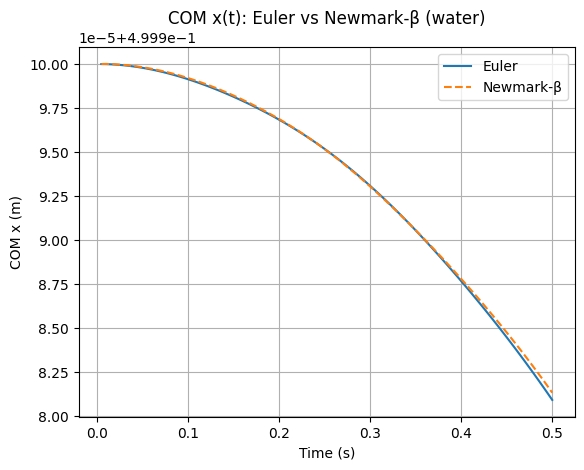

In [43]:
#------------------------------------------------------------
# EXAMPLE 1: Compare implicit Euler vs Newmark-β in water
# ------------------------------------------------------------

# You can comment out any of these blocks if you don't want them to run automatically.

totalTime_compare = 0.5
dt_compare = 0.005
kappa_compare = 0.5

res_euler = run_tail_simulation(
    integrator="euler",
    medium="water",
    kappa_amp=kappa_compare,
    totalTime=totalTime_compare,
    dt=dt_compare
)

res_newmark = run_tail_simulation(
    integrator="newmark",
    medium="water",
    kappa_amp=kappa_compare,
    totalTime=totalTime_compare,
    dt=dt_compare
)

print("\n=== Euler vs Newmark-β in water ===")
print(f"Euler   net Δx = {res_euler['net_dx']:.4e},  max|y| = {res_euler['max_abs_y']:.4e}")
print(f"Newmark net Δx = {res_newmark['net_dx']:.4e},  max|y| = {res_newmark['max_abs_y']:.4e}")

plt.figure()
plt.plot(res_euler["time"], res_euler["com_x"], label="Euler")
plt.plot(res_newmark["time"], res_newmark["com_x"], label="Newmark-β", linestyle="--")
plt.xlabel("Time (s)")
plt.ylabel("COM x (m)")
plt.title("COM x(t): Euler vs Newmark-β (water)")
plt.grid(True)
plt.legend()
plt.show()



=== FULL MULTI-PARAMETER SWEEP (Implicit Euler objfun) ===

Case |     net Δx |     max|y| |       <Es> |       <Eb> |       <Ek> |       <Pv>
------------------------------------------------------------------------------------------
   1 | -1.176e-05 |  2.409e-06 |  0.000e+00 |  0.000e+00 |  0.000e+00 |  0.000e+00
   2 | -1.774e-05 |  1.640e-06 |  0.000e+00 |  0.000e+00 |  0.000e+00 |  0.000e+00
   3 | -2.366e-05 |  1.251e-06 |  0.000e+00 |  0.000e+00 |  0.000e+00 |  0.000e+00
   4 | -1.763e-05 |  2.177e-06 |  0.000e+00 |  0.000e+00 |  0.000e+00 |  0.000e+00
   5 | -2.709e-05 |  1.571e-06 |  0.000e+00 |  0.000e+00 |  0.000e+00 |  0.000e+00
   6 | -3.685e-05 |  2.465e-06 |  0.000e+00 |  0.000e+00 |  0.000e+00 |  0.000e+00
   7 | -1.120e-02 |  2.153e-03 |  0.000e+00 |  0.000e+00 |  0.000e+00 |  0.000e+00
   8 | -1.688e-02 |  1.520e-03 |  0.000e+00 |  0.000e+00 |  0.000e+00 |  0.000e+00
   9 | -2.244e-02 |  1.180e-03 |  0.000e+00 |  0.000e+00 |  0.000e+00 |  0.000e+00
  10 | -1.663e-02 

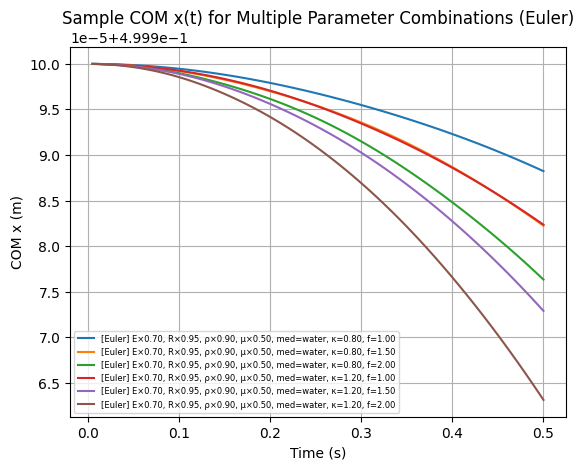

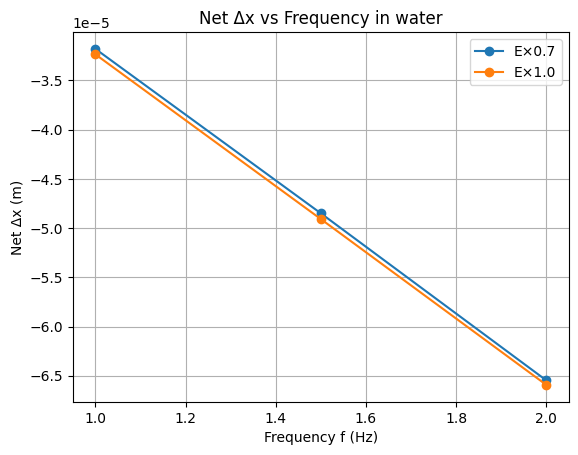

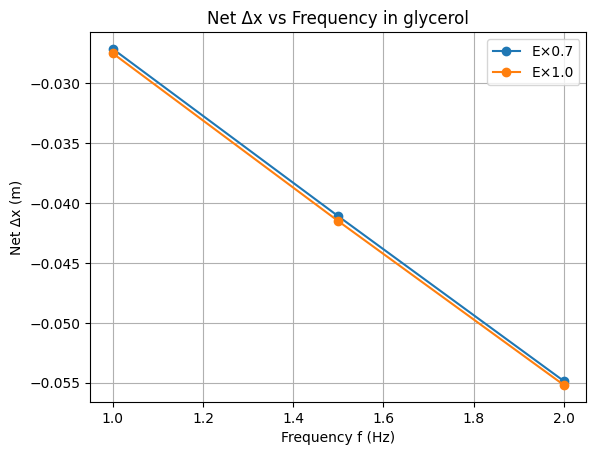

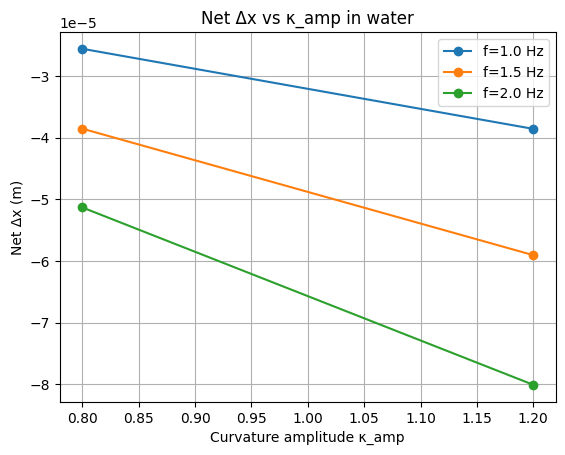

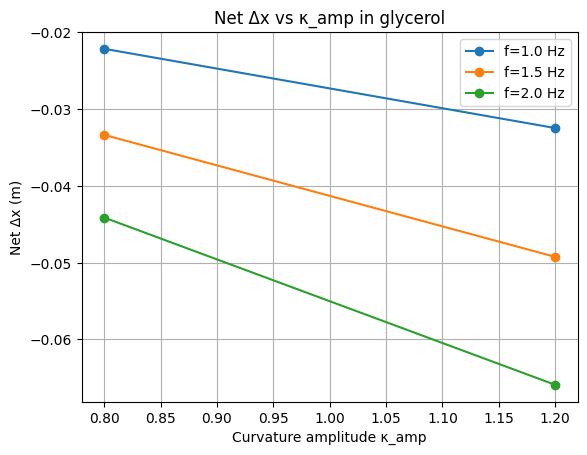

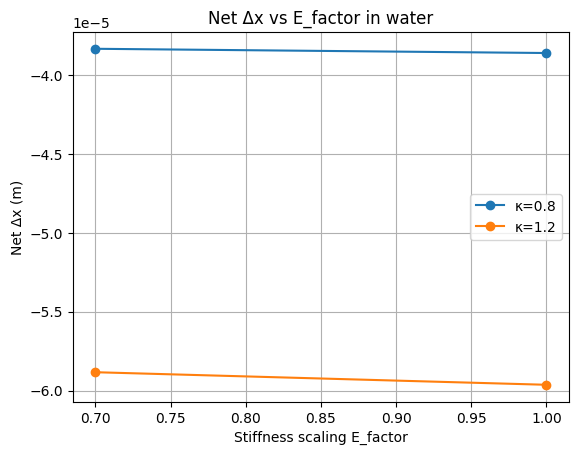

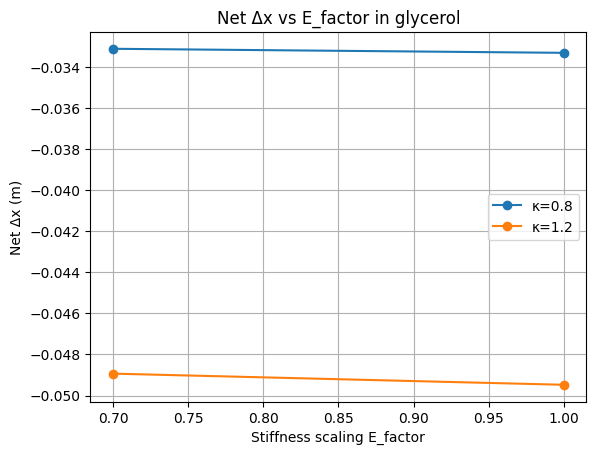

In [44]:
def run_full_parameter_sweep_euler():
    """
    Full proposal-style multi-parameter sweep using the GENERAL implicit Euler
    integrator (objfun), NOT Newmark-β, but with a reduced grid so the total
    number of cases is manageable.

    Sweeps over:
      - E_factor
      - radius_factor
      - rho_factor
      - visc_factor
      - medium
      - kappa_amp
      - frequency
    """

    # Reduced grids: 2–3 values each → 2*2*2*2*2*2*3 = 192 cases total
    E_factors      = [0.7, 1.0]          # stiffness (E)
    radius_factors = [0.95, 1.05]        # geometry
    rho_factors    = [0.9, 1.1]          # density
    visc_factors   = [0.5, 2.0]          # fluid viscosity scaling
    media_list     = ["water", "glycerol"]
    kappa_list     = [0.8, 1.2]          # curvature amplitude
    freq_list      = [1.0, 1.5, 2.0]     # actuation frequency

    totalTime_sweep = 0.5
    dt_sweep        = 0.005

    all_results = []

    print("\n=== FULL MULTI-PARAMETER SWEEP (Implicit Euler objfun) ===\n")
    print(f"{'Case':4s} | {'net Δx':>10s} | {'max|y|':>10s} | {'<Es>':>10s} | "
          f"{'<Eb>':>10s} | {'<Ek>':>10s} | {'<Pv>':>10s}")
    print("-"*90)

    case_id = 0
    for Efac in E_factors:
        for Rfac in radius_factors:
            for rhofac in rho_factors:
                for viscfac in visc_factors:
                    for med in media_list:
                        for kap in kappa_list:
                            for f in freq_list:
                                case_id += 1
                                res = simulate_tail_case_euler(
                                    E_factor=Efac,
                                    radius_factor=Rfac,
                                    rho_factor=rhofac,
                                    visc_factor=viscfac,
                                    medium=med,
                                    kappa_amp=kap,
                                    freq=f,
                                    drag_ratio=5.0,
                                    totalTime=totalTime_sweep,
                                    dt=dt_sweep
                                )
                                all_results.append(res)
                                print(f"{case_id:4d} | "
                                      f"{res['net_dx']:10.3e} | "
                                      f"{res['max_abs_y']:10.3e} | "
                                      f"{res['mean_Es']:10.3e} | "
                                      f"{res['mean_Eb']:10.3e} | "
                                      f"{res['mean_Ek']:10.3e} | "
                                      f"{res['mean_Pv']:10.3e}")

    # Quick visual sanity check: some COM x(t) curves
    plt.figure()
    for res in all_results[:min(6, len(all_results))]:
        plt.plot(res["time"], res["com_x"], label=res["label"])
    plt.xlabel("Time (s)")
    plt.ylabel("COM x (m)")
    plt.title("Sample COM x(t) for Multiple Parameter Combinations (Euler)")
    plt.grid(True)
    plt.legend(fontsize=6)
    plt.show()

    return all_results

import pandas as pd
import matplotlib.pyplot as plt

def sweep_results_to_df(all_sweep_results):
    """
    Convert list of sweep result dicts into a pandas DataFrame.
    Each row corresponds to one parameter combination.
    """
    rows = []
    for res in all_sweep_results:
        row = {
            "net_dx": res["net_dx"],
            "max_abs_y": res["max_abs_y"],
            "mean_Es": res["mean_Es"],
            "mean_Eb": res["mean_Eb"],
            "mean_Ek": res["mean_Ek"],
            "mean_Pv": res["mean_Pv"],
        }
        # Add parameters from the nested dict
        for k, v in res["params"].items():
            row[k] = v
        rows.append(row)
    return pd.DataFrame(rows)


def plot_net_dx_vs_freq(df):
    """
    Plot net forward distance vs frequency for each medium and E_factor.

    We average over other parameters (rho_factor, visc_factor, etc.)
    to avoid vertical clusters at the same frequency.
    """
    for med in df["medium"].unique():
        df_med = df[df["medium"] == med]
        plt.figure()
        for Efac in sorted(df_med["E_factor"].unique()):
            sub = df_med[df_med["E_factor"] == Efac]
            # group by frequency and average net_dx
            agg = sub.groupby("freq", as_index=False)["net_dx"].mean()
            agg = agg.sort_values("freq")
            plt.plot(agg["freq"], agg["net_dx"], "o-", label=f"E×{Efac}")
        plt.xlabel("Frequency f (Hz)")
        plt.ylabel("Net Δx (m)")
        plt.title(f"Net Δx vs Frequency in {med}")
        plt.grid(True)
        plt.legend()
        plt.show()


def plot_net_dx_vs_kappa(df):
    """
    Plot net forward distance vs curvature amplitude for each medium.

    We average over other parameters at each (κ_amp, f) pair.
    """
    for med in df["medium"].unique():
        df_med = df[df["medium"] == med]
        plt.figure()
        for f in sorted(df_med["freq"].unique()):
            sub = df_med[df_med["freq"] == f]
            agg = sub.groupby("kappa_amp", as_index=False)["net_dx"].mean()
            agg = agg.sort_values("kappa_amp")
            plt.plot(agg["kappa_amp"], agg["net_dx"], "o-",
                     label=f"f={f:.1f} Hz")
        plt.xlabel("Curvature amplitude κ_amp")
        plt.ylabel("Net Δx (m)")
        plt.title(f"Net Δx vs κ_amp in {med}")
        plt.grid(True)
        plt.legend()
        plt.show()


def plot_net_dx_vs_E(df):
    """
    Plot net forward distance vs stiffness scaling E_factor (for each medium).

    We average over other parameters at each (E_factor, κ_amp) pair.
    """
    for med in df["medium"].unique():
        df_med = df[df["medium"] == med]
        plt.figure()
        for kap in sorted(df_med["kappa_amp"].unique()):
            sub = df_med[df_med["kappa_amp"] == kap]
            agg = sub.groupby("E_factor", as_index=False)["net_dx"].mean()
            agg = agg.sort_values("E_factor")
            plt.plot(agg["E_factor"], agg["net_dx"], "o-",
                     label=f"κ={kap}")
        plt.xlabel("Stiffness scaling E_factor")
        plt.ylabel("Net Δx (m)")
        plt.title(f"Net Δx vs E_factor in {med}")
        plt.grid(True)
        plt.legend()
        plt.show()

# ============================================================
# RUN FULL PARAMETER SWEEP (EULER / objfun) + PLOT RESULTS
# ============================================================

if __name__ == "__main__":

    # 1) Run the full multi-parameter sweep using the GENERAL implicit Euler objfun
    all_sweep_results = run_full_parameter_sweep_euler()

    # 2) Convert results to a DataFrame
    df_sweep = sweep_results_to_df(all_sweep_results)

    # 3) Generate plots
    plot_net_dx_vs_freq(df_sweep)
    plot_net_dx_vs_kappa(df_sweep)
    plot_net_dx_vs_E(df_sweep)
